<a href="https://colab.research.google.com/github/MarcoChilese/TUDASummerSchool22/blob/main/TUDA_FL_Tutorial_ToComplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The hitchhiker's guide to the Security and Privacy of Federated Learning**
# **Introduction**
This notebook provides you with some practical exercises to get a first look into Federated Learning (FL) and targeted poisoning attacks (a.k.a backdoor) on FL. First, we implement a simple FL scenario where we distribute tasks for training a Neural Network (NN) for image classification on the CIFAR10 dataset (60k images from 10 categories). Then, different attack strategies and defenses against the attacks will be implemented. 

**General Advice**:

* Some parts of the code require a machine that is more powerful than a standard laptop. We recommend the usage of Google colab. You need to upload this notebook to: https://colab.research.google.com/

    * To speedup the execution, you should use a GPU in colab. Go to "Runtime" -> "Change Runtime Type" and select "GPU" as "Hardware accelerator"
    * At one point, an additional artifact is needed. The notebook will download it automatically such that you do not need to do anything except executing the respective cells.
* All the tasks are enumerated. The description of each task starts with TASK_TO_DO. All parts where you need to implement something starts with "### IMPLEMENTATION START ###" and ends with "### IMPLEMENTATION END ###". Outside these places, no changes are necesarry.
* The tasks are built on top of each other. To avoid getting stuck in a single task, the solutions for the tasks will be made available at: https://dst.trust.informatik.tu-darmstadt.de/drive/d/s/p0KjxWSAKAO2mxPJyqpqyZ5I1HSjTUFw/YLi67jxxnqXqYXre9WPKfOsrr1RDm8h_-0bDg3AMGlQk


## Useful Hints for Completing the Tutorial

### Appending items to list
For inserting a new item to a list, you can use the following function:
```python
x = [1,2,3]
x.append(4)
# x = [1,2,3,4]
```


### Mean, Standard Deviation, Median
For computing mean, standard deviation and median, you can use the following `numpy` function:
```python
x = [1,2,3,4,5]
x_mean = np.mean(x)
x_std = np.std(x)
x_median = np.median(x)
```

### Tensors
In order to create a Tensor, you should use `torch.Tensor(data)`. <br>
E.g.:
```python
x = [[1,2], [2,3]]
x_tensor = torch.Tensor(x)
```

### Creating an empty tensor with known shape
Considering an existing tensor with fixed shape (i.e., dimension), for creating a new tensor of zeros with the same shape you can use the following function:
```python
x = torch.Tensor(...)
new_empty_tensor = torch.zeros_like(x)
```


### Changing computation device
For moving data from a computation device to another, you should use the following functions:
```python
# moves data in GPU to CPU and stores it in the variable data_cpu
data_cpu = data.cpu()

# moves data in CPU to GPU and stores it in the variable data_gpu
data_gpu = data.cuda()
```



# **Install and Import Necessary Modules**

In [ ]:
# Installation
!python -m pip install git+https://github.com/MarcoChilese/TUDASummerSchool22Code
from TUDASummerSchool22.Utils import *
from TUDASummerSchool22.DataLoader import *
from TUDASummerSchool22.ResNet18Light import *
from TUDASummerSchool22.ModelUtils import *
from TUDASummerSchool22.TrainingUtils import *
from TUDASummerSchool22.ModelStateDictNames import *
from TUDASummerSchool22.PoisoningUtils import *

#Imports
import torch
from torch import nn
import datetime
import random
import numpy as np
from pprint import pprint
from torchvision import datasets, transforms
from collections import defaultdict
import math
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import time
from torch.nn.functional import cross_entropy
!pip3 install pytorch-lightning
from pytorch_lightning import seed_everything
seed_everything(42) # reproducibility 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MarcoChilese/TUDASummerSchool22 to /tmp/pip-req-build-izl7u8fa
  Running command git clone -q https://github.com/MarcoChilese/TUDASummerSchool22 /tmp/pip-req-build-izl7u8fa
     |████████████████████████████████| 51 kB 553 kB/s 
     |████████████████████████████████| 251 kB 14.4 MB/s 
  Created wheel for TUDASummerSchool: filename=TUDASummerSchool-0.1.2-py3-none-any.whl size=9019 sha256=3ed94222cdcb3048555f877c3c6f66ed1f95eb01ef4cec6eb7d9581e453fbcae
  Stored in directory: /tmp/pip-ephem-wheel-cache-_9n3eudm/wheels/b1/14/79/01af2b5a842792c27d00455e1de11267878e8d34e832074b79
Successfully built TUDASummerSchool
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 9.9 MB/s 
     |████████████████████████████████| 140 kB 73.0 MB/s 
     |████████████████████████████████| 

Global seed set to 42


42

# **Federated Learning**
We start with some general setup for FL, e.g., defining some parameters, loading the data, define the NN architecture and train the models of the benign clients.

## Configuration Parameters

In [ ]:
# Define parameters
TOTAL_CLIENT_NUMBER = 30
POISONED_MODEL_RATE = 1/3
NUMBER_OF_ADVERSARIES = int(TOTAL_CLIENT_NUMBER * POISONED_MODEL_RATE)
NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_ADVERSARIES
IID_RATE = 0.9
SAMPLES_PER_CLIENT = 384
BATCH_SIZE = 64
LOCAL_EPOCHS_FOR_BENIGN_CLIENTS = 2

#Send computation to a gpu if exists
USE_GPU = True if torch.cuda.is_available() else False
COMPUTATION_DEVICE = torch.device(f"cuda:{0}" if USE_GPU else "cpu")

In [ ]:
if not USE_GPU:
  raise Exception('To speed up the tutorial, you should enable GPU support (see notes in the beginning)')

## Load Data and Create Dataset

Now, we load the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60k images in total, devided into 50k images for training and 10k images for testing. Training and test data are disjoint for measuring the generalization ability of the model.

Now, we divide the training data into 30 local datasets of the individual clients. To make the data distribution more realistic (clinets with different data distribution), we randomly distibute image labels (e.g., AUTOMOBILE) among clients such that each client will receive a certain amount of images (main label) only from a certain category (e.g., only automobiles) and the rest of the images are random samples from all available images.

For this, we first sort the images by labels to allow sampling only from a certain class. The function create_client_distributions then randomly selects the main label for each client, chooses the specified fraction of images (1-IID_RATE; IID_RATE was defined above as a constant value) from this main label and sample the remaining images from all available training images.

In [ ]:
# Labels in the dataset
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# To achieve a better performance by the ML model, the images are normalized. These values were calculated in advance and put here statically.
STD_DEV = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
MEAN = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))

# Transfroming and augmenting images 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

# Load the data, store the images and their corresponding labels
DATA_DIRECTORY = './data'
train_dataset = datasets.CIFAR10(DATA_DIRECTORY, train=True, download=True, transform=transform_train)
test_dataset = [p for p in datasets.CIFAR10(DATA_DIRECTORY, train=False, transform=transform_test)]

# Create client distributions
train_data_by_labels, all_labels, all_training_images = sort_samples_by_labels(train_dataset)
all_data_indices, main_labels_dict = create_client_distributions(TOTAL_CLIENT_NUMBER, IID_RATE, SAMPLES_PER_CLIENT,all_labels=all_labels, train_data_by_labels=train_data_by_labels,all_training_images=all_training_images)

# Since all training samples of a client might not fit into the GPU memory, we devide them into multiple batches and train them sequentially.
all_training_data = [MyDataLoader(train_dataset, indices, BATCH_SIZE) for indices in tqdm(all_data_indices)]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


50000it [00:18, 2707.49it/s]


2022-06-14 11:39:54.321946: Samples from main class per client: 38
2022-06-14 11:39:54.322051: Samples from all classes per client: 346
2022-06-14 11:39:54.358180: Main label for clients: {0: 6, 1: 3, 2: 7, 3: 4, 4: 6, 5: 9, 6: 2, 7: 6, 8: 7, 9: 4, 10: 3, 11: 7, 12: 7, 13: 2, 14: 5, 15: 4, 16: 1, 17: 7, 18: 5, 19: 1, 20: 4, 21: 0, 22: 9, 23: 5, 24: 8, 25: 0, 26: 9, 27: 2, 28: 6, 29: 3} 


100%|██████████| 30/30 [00:03<00:00,  8.10it/s]


To better grasp what we are working on, we will pick one image to visualize it.

In [ ]:
# Chose an example to visualize
example_dataset = all_training_data[0]
example_image = example_dataset.batches[0][0][-2]
example_label = example_dataset.batches[0][1][-2]
print_timed(f'The taken example has label {example_label}: {CLASSES[example_label]}')

2022-06-14 11:39:58.086417: The taken example has label 7: Horse


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2022-06-14 11:39:58.101083: Shape of image: torch.Size([3, 32, 32])


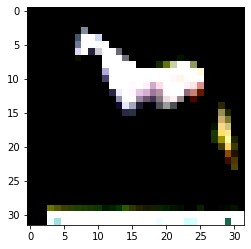

In [ ]:
print_timed(f'Shape of image: {example_image.shape}')
_ = plt.imshow(example_image.permute((1, 2, 0)))

Visualizing these normalized images gives us humans only a small insight. Therefore, we now revert this normalization and display it again.

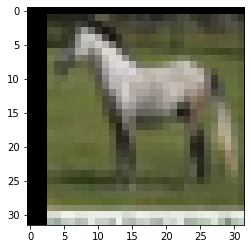

In [ ]:
_ = plt.imshow(unnormalize_image(example_image, STD_DEV=STD_DEV, MEAN=MEAN))

Plot further examples:

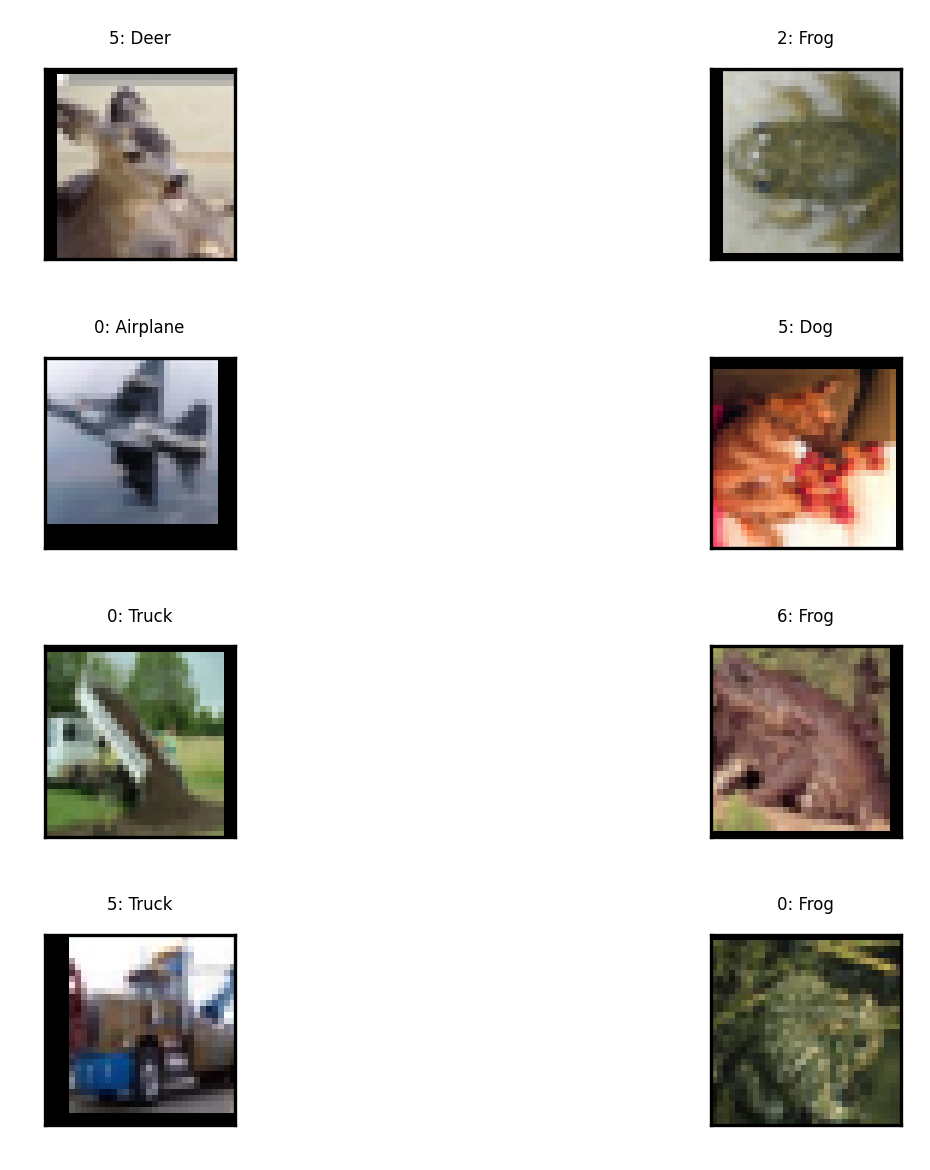

In [ ]:
fig, axs = plt.subplots(4, 2,dpi=300)

for i in range(0, 8):
    x = int(i//4)
    y = i % 4
    axs[y,x].set_title(f'{example_dataset.batches[0][1][i]}: {CLASSES[example_dataset.batches[1][1][i]]}', fontsize=4)
    axs[y,x].imshow(unnormalize_image(example_dataset.batches[1][0][i], STD_DEV, MEAN))
    axs[y,x].get_xaxis().set_visible(False)
    axs[y,x].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

## Global Model Initialization
### Deep Neural Network Architecture
Let's now define the architecture of the NN that we will be using in this tutorial.
Since we are going to do an image classification task, we utilize a Convolutional Neural Network (CNN). Our CNN shares the same architecture as ResNet [1,2] but is more lightweight and has less trainable parameters leading to a simple training process.


If you are interested in seeing the model architecture, you can have a look [here](https://github.com/MarcoChilese/TUDASummerSchool22/tree/main#model-architecture---resnet18-light).

[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun Deep Residual Learning for Image Recognition. arXiv:1512.03385

[2] https://pytorch.org/hub/pytorch_vision_resnet/

### Instantiation of a global model (Server-side)

In [ ]:
# instantiate the model
global_model = ResNet18Light('GlobalModel')

In [ ]:
input_names = ['Image']
output_names = ['Labels']
torch.onnx.export(global_model, torch.rand(1,3,32,32), 'model.onnx', input_names=input_names, output_names=output_names)

#### Check Global Model Accuracy before training
Let's now see, how well the model performs on the data before training. We implement a function that uses the model to predict the classes and counts the number of correclty predicted images (checked against ground-truth labels).

In [ ]:
# Prepare some data for testing
test_data = batchify(test_dataset, 1024, len(test_dataset))

# Move the global model the gpu and test its initial perfromance
global_model.to(COMPUTATION_DEVICE)
test_data = [(x.to(COMPUTATION_DEVICE), y.to(COMPUTATION_DEVICE)) for x, y in test_data]
print(f'Accuracy: {test(test_data, global_model)}%')

2022-06-14 11:40:16.405008: ___Test GlobalModel_ResNet_18: Average loss: 2.3028, Accuracy: 1000/10000 (10.0000%)
Accuracy: 10.0%


The performance of this model is not acceptable, as the model parameters were randomly initialized but not trained yet. Let's have a look on the predictions in more detail before continuing.

Prediction Distribution: {4: 1024}


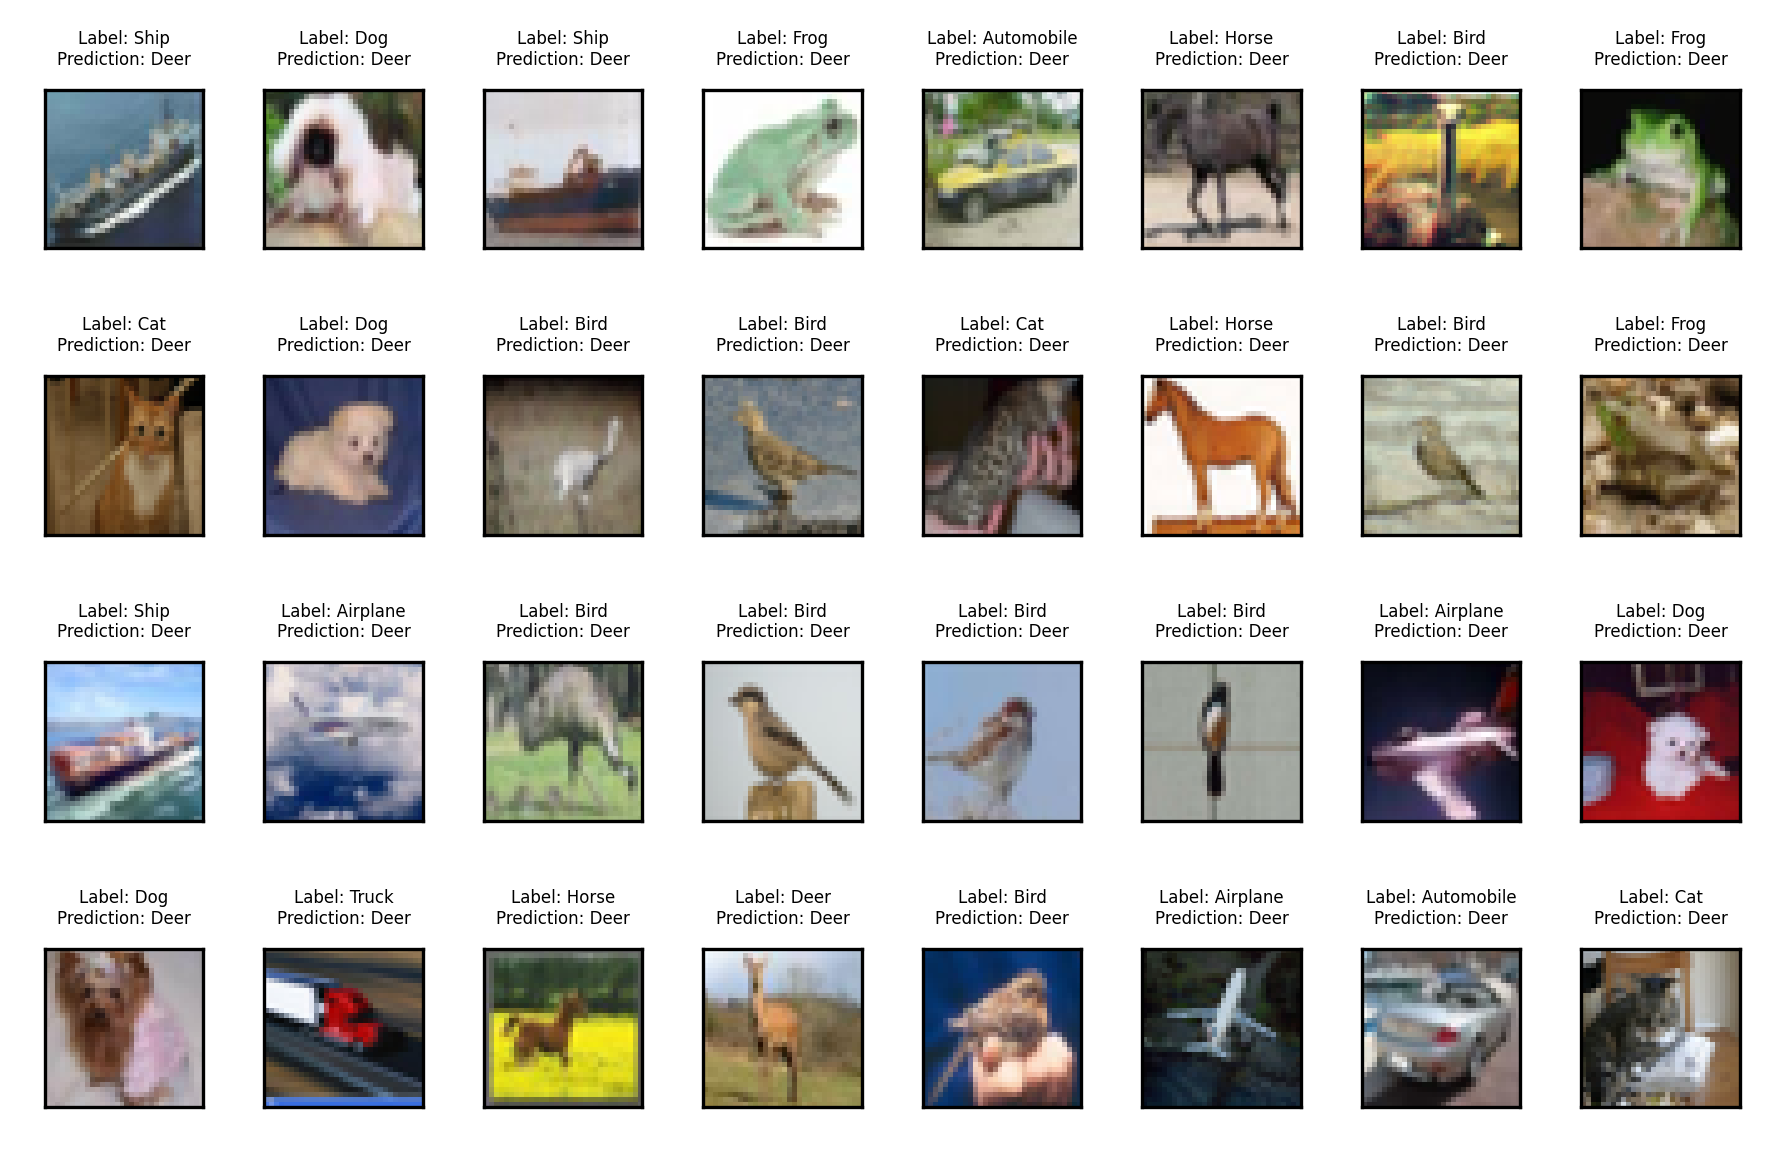

In [ ]:
visualize_model_predictions(test_data, global_model, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

### Load Pretrained Model
Unfortunately, the model accuracy of 10% is quite low. To avoid a long training process until the model achieves a suitable accuracy, we use an already pre-trained model. The pretrained model is in an intermediate state, where the training is not finished yet. Most of its predictions are correct, however, further training is needed to improve its performance.

In [ ]:
# Download the pretrained model
!wget https://docs.trust-sysec.com/FF9FB2E7-7460-48D9-BFF8-529D6C528CD6/R0099.pt

--2022-06-14 11:40:17--  https://docs.trust-sysec.com/FF9FB2E7-7460-48D9-BFF8-529D6C528CD6/R0099.pt
Resolving docs.trust-sysec.com (docs.trust-sysec.com)... 130.83.40.134
Connecting to docs.trust-sysec.com (docs.trust-sysec.com)|130.83.40.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11231292 (11M) [application/octet-stream]
Saving to: ‘R0099.pt’

R0099.pt            100%[===================>]  10.71M  8.19MB/s    in 1.3s    

2022-06-14 11:40:19 (8.19 MB/s) - ‘R0099.pt’ saved [11231292/11231292]



In [ ]:
# Load the pretrained model and check the accuracy again
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

test(test_data, global_model)

2022-06-14 11:40:20.992454: ___Test GlobalModel_ResNet_18: Average loss: 0.8361, Accuracy: 7486/10000 (74.8600%)


74.86

This looks better now, almost 75% of all images are predicted correctly.

Prediction Distribution: {0: 122, 1: 113, 2: 72, 3: 46, 4: 129, 5: 69, 6: 168, 7: 88, 8: 114, 9: 103}


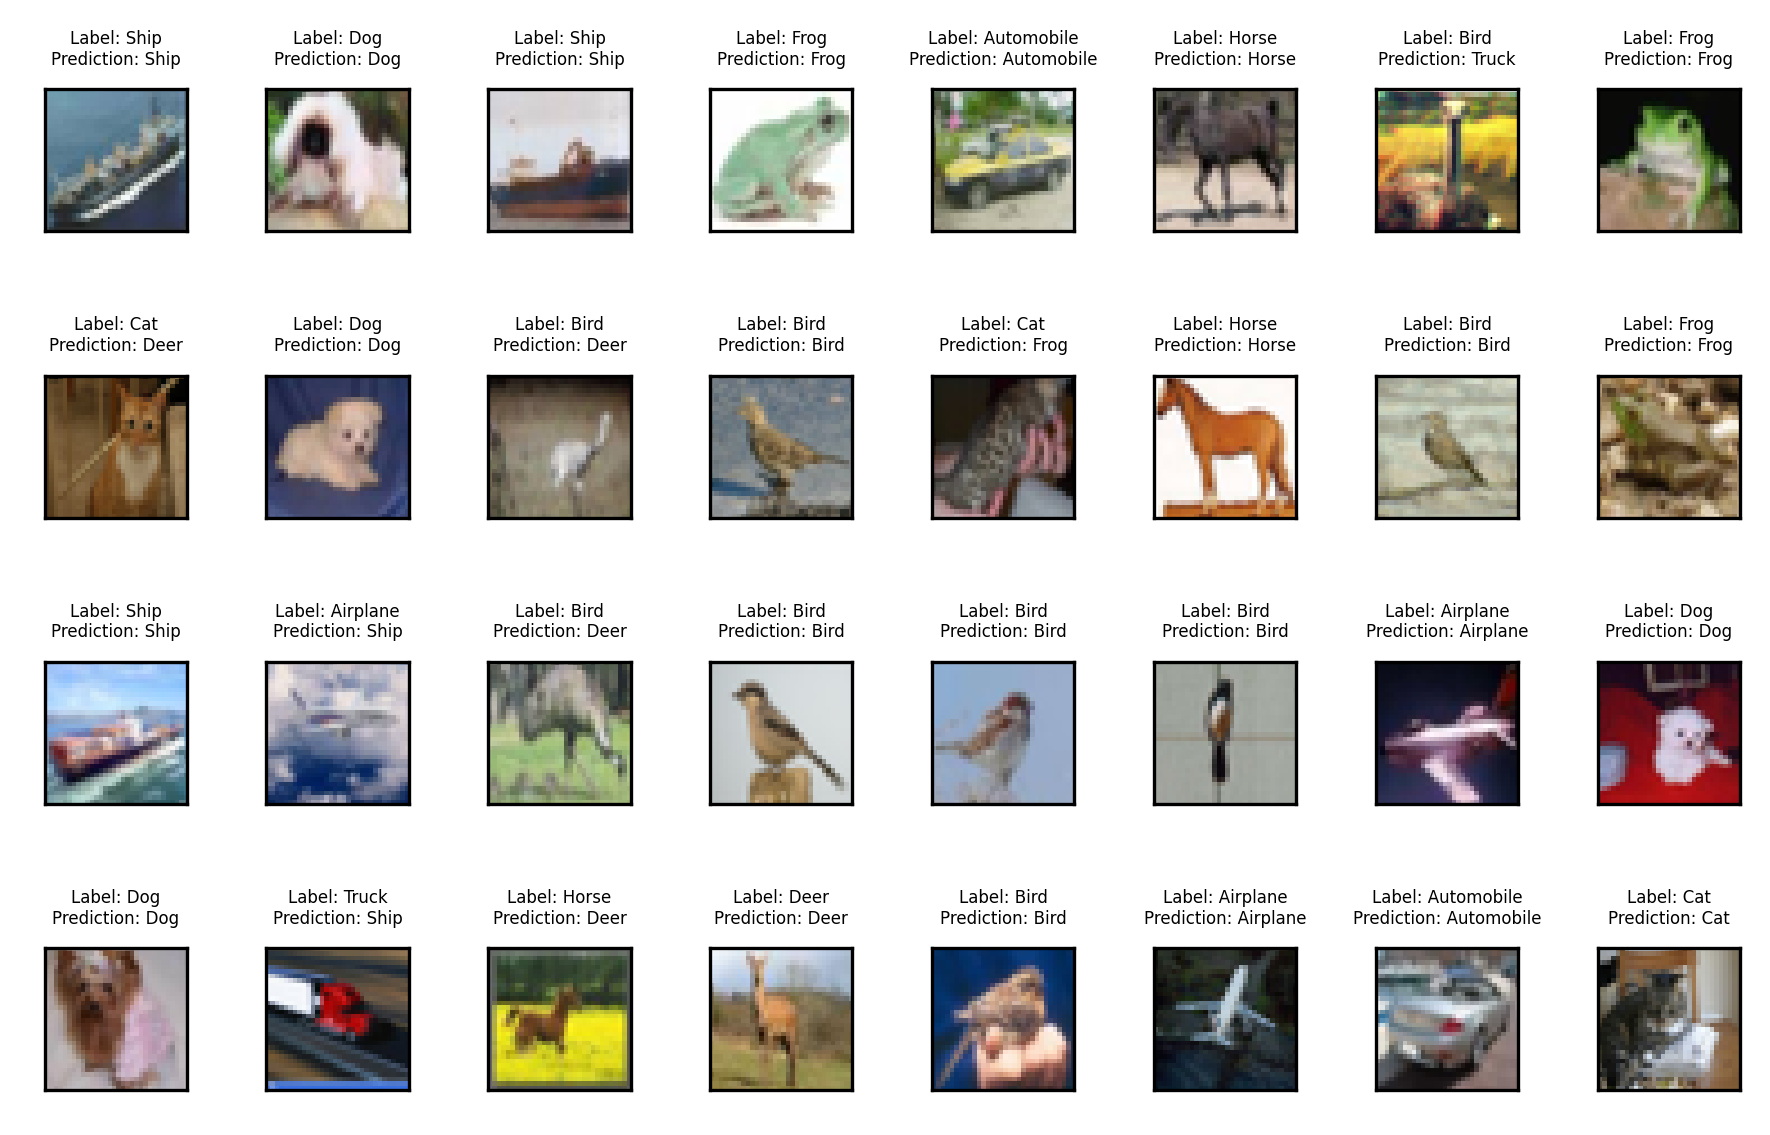

In [ ]:
visualize_model_predictions(test_data, global_model, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

## Local Model Training (Client-side)
Let's take a look into the training process.

Now we can train the local model of a single client based on its local dataset. For this, we copy the global model into the local model and then (continue) the training for a number of epochs.


The function `train_benign_client` performs the training of the client model as follows:
```python
def train_benign_client(global_model_state_dict, local_model, local_training_data, COMPUTATION_DEVICE, local_epochs, lr)
```
Full implementation available [here](https://github.com/MarcoChilese/TUDASummerSchool22/blob/46b5503e2429dc639ca25eef37de4ad0d466b690/TUDASummerSchool22/TrainingUtils.py#L8).

In [ ]:
local_model = ResNet18Light('LocalModel').to(COMPUTATION_DEVICE)
_ = train_benign_client(global_model_state_dict, local_model, all_training_data[0], local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
test(test_data, local_model)

2022-06-14 11:40:22.933890: local_epoch   0 | lr 0.2 | ms/batch 346.43| loss  4.04
2022-06-14 11:40:23.090530: local_epoch   1 | lr 0.2 | ms/batch 156.46| loss  1.05
2022-06-14 11:40:23.954507: ___Test LocalModel_ResNet_18: Average loss: 1.2517, Accuracy: 6353/10000 (63.5300%)


63.53

Suprisingly, the accuracy of the model decreased!
However, we are still in the beginning of training. The accuracy will increase when we continue utilizing FL.


### Federated Training (Simulation)
Now we train the clients in a federated setting:

In [ ]:
all_trained_benign_models = []
for client_index in range(NUMBER_OF_BENIGN_CLIENTS):
    print_timed(f'Client {client_index}')
    trained_model = train_benign_client(global_model_state_dict, local_model, all_training_data[client_index], printing_prefix='\t', local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
    all_trained_benign_models.append(trained_model)

2022-06-14 11:40:23.971236: Client 0
2022-06-14 11:40:24.118724: 	local_epoch   0 | lr 0.2 | ms/batch 138.95| loss  4.04
2022-06-14 11:40:24.259854: 	local_epoch   1 | lr 0.2 | ms/batch 140.43| loss  1.05
2022-06-14 11:40:24.269795: Client 1
2022-06-14 11:40:24.413653: 	local_epoch   0 | lr 0.2 | ms/batch 139.97| loss  4.53
2022-06-14 11:40:24.556234: 	local_epoch   1 | lr 0.2 | ms/batch 142.44| loss  1.25
2022-06-14 11:40:24.567413: Client 2
2022-06-14 11:40:24.714610: 	local_epoch   0 | lr 0.2 | ms/batch 143.37| loss  3.52
2022-06-14 11:40:24.856991: 	local_epoch   1 | lr 0.2 | ms/batch 142.24| loss  0.92
2022-06-14 11:40:24.870121: Client 3
2022-06-14 11:40:25.015540: 	local_epoch   0 | lr 0.2 | ms/batch 140.99| loss  4.19
2022-06-14 11:40:25.156603: 	local_epoch   1 | lr 0.2 | ms/batch 140.93| loss  1.00
2022-06-14 11:40:25.169488: Client 4
2022-06-14 11:40:25.313906: 	local_epoch   0 | lr 0.2 | ms/batch 139.72| loss  3.39
2022-06-14 11:40:25.455050: 	local_epoch   1 | lr 0.2 | ms/

### Model Parameters
Now we have trained multiple benign models and stored the trained parameters of each of them. Let's have a look on how the stored parameters look like.

A Neural Network model is given by its architecture and the values of its parameters. The architecture was defined above and is always the same in this notebook. Therefore, we don't need to store this information all the time and can focus on the parameters.

The parameters are stored in a state dict, which is a simple Python dictionary object that maps each layer to its learnable parameters (i.e., weights and biases).

More info:

https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html

In [ ]:
# Take a model as an example 
example_model = all_trained_benign_models[0]


print(f'Type of the model {type(example_model)}')
print(f'The model parameters are stored in the dictionary called state-dicts. The keys are name of the layers and the values are trainable parameters (i.e., tensors or multi-dimensional arrays) corresponding to keys.')
print()
pprint(f'Keys: {example_model.keys()}')
print()
print('Let us now have a look on an example.')
example_parameter = example_model['conv1.weight']
print(f'conv1.weight: {type(example_parameter)}')
print(f'The conv1.weight has the shape: {example_parameter.shape} .')

Type of the model <class 'dict'>
The model parameters are stored in the dictionary called state-dicts. The keys are name of the layers and the values are trainable parameters (i.e., tensors or multi-dimensional arrays) corresponding to keys.

("Keys: dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', "
 "'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', "
 "'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', "
 "'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', "
 "'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', "
 "'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', "
 "'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', "
 "'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', "
 "'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', "
 "'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', "
 "'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', "
 "'l

In [ ]:
print('linear.weight = ' + str(example_model['linear.weight']))

linear.weight = tensor([[-0.4064, -0.1417, -0.1298,  ..., -0.2379, -0.1092, -0.0122],
        [-0.3574,  0.2057, -0.0622,  ...,  0.9931,  0.2933, -0.0906],
        [ 0.1891, -0.1098,  0.0274,  ..., -0.2176, -0.2093, -0.1522],
        ...,
        [ 0.5536,  0.2279,  0.2824,  ..., -0.1971, -0.2204, -0.1227],
        [-0.3584, -0.0256, -0.0844,  ..., -0.3746, -0.1998,  0.2160],
        [-0.3745, -0.2313,  0.0183,  ...,  0.8300,  0.3760, -0.0252]])


In [ ]:
print(f'A tensor can be either stored in the main memory (cpu) or in the memory of a gpu. The example parameter is stored on {example_parameter.device} memory.')

A tensor can be either stored in the main memory (cpu) or in the memory of a gpu. The example parameter is stored on cpu memory.


In [ ]:
print(f'The same holds for the parameters of the global model (as tensors). However, here the computation device is different: {global_model_state_dict["conv1.weight"].device}')

The same holds for the parameters of the global model (as tensors). However, here the computation device is different: cuda:0


Unfortunately, the GPU memory is usually quite limited, therefore, we have to outsource the parameters of the local models to the CPU memory whenever it is possible. Since we need to frequently evaluate the global model, we keep this in the GPU memory.

Note that we cannot simply compare or combine tensors stored on different devices (CPU or GPU). Please keep this in mind, when doing the following tasks.

Be aware of the difference between a model object and a state-dict. The state-dict is just a dictionary containing the layers and their trainable parameters. However, to do a prediction, we need to load the state-dict into a model object (instances of Resnet18Light).

## Model Aggregation
After showing how the individual parameters are stored, your task is now to aggregate the individual local models using Federated Averaging (FedAvg). According to the initial paper of FL [3], FedAvg determines the aggregated model $G_t$ from N local models $W_0, \ldots, W_{N-1}$ as: 
$$ G_T = \frac{1}{N}\sum_{i=0}^{N} W_i$$

The FedAvg algorithm proposed in previous work is a little bit more complex and includes, e.g., a learning rate $\eta$ and the individual clients' contributions are weighted according to their dataset sizes. However, to keep this tutorial simple, we use this simplified version of FedAvg here.

[3] McMahan, Brendan, et al. "Communication-efficient learning of deep networks from decentralized data." Artificial intelligence and statistics. PMLR, 2017.

http://proceedings.mlr.press/v54/mcmahan17a/mcmahan17a.pdf

In [ ]:
# Important note: do not forget to execute this cell
hash_values = get_models_hash(all_trained_benign_models)

### Task 1: Model Aggregation

⏳ **20min**

TASK_TO_DO: Your task is now to implement FedAvg. The code below aggregates the individual benign models into a single global model and evaluates the aggregated model. Please aggregate only the parameters where the names are in NAMES_OF_TRAINED_PARAMETERS (simply copy the other parameters from the base_model). Please also keep the different memory locations (CPU memory vs. GPU memory) in mind.

Hint: If you implemented the aggregation correctly, the aggregated model should achieve a (main-task) accuracy above 80%.

In [ ]:
def aggregate_models(all_models, base_model, verbose=True):
    """
    Perform FedAvg algorithm
    :param all_models list of state dicts, containing the locally trained parameters of the individual clients
    :param base_model state dict of arbitrary model, useful for knowing the names of all parameters and copying values of not 
    aggregated parameters
    :return state dict of aggregated model (obtained by FedAvg)
    """
    
    if verbose:
        print_timed(f'Aggregate {len(all_models)} models')
   
    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()} 
    n_models = len(all_models) 

    ### IMPLEMENTATION START ###
    # HINT: 
    # iterate on all models
    # if the layer is in NAMES_OF_AGGREGATED_PARAMETERS
    # then ...
    # else ...

    
    ### IMPLEMENTATION END ###
    return result_state_dict


aggregated_weights = aggregate_models(all_trained_benign_models, global_model_state_dict)
check_hashs(all_trained_benign_models, hash_values)
print_timed(f'First test the previous model for comparison')
_ = test(test_data, global_model)
print()
print_timed(f'Now test the aggregated model')
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
aggregated_model.load_state_dict(aggregated_weights)
_ = test(test_data, aggregated_model)

2022-06-14 11:40:30.238016: Aggregate 20 models
2022-06-14 11:40:30.559768: First test the previous model for comparison
2022-06-14 11:40:31.415238: ___Test GlobalModel_ResNet_18: Average loss: 0.8361, Accuracy: 7486/10000 (74.8600%)

2022-06-14 11:40:31.415519: Now test the aggregated model
2022-06-14 11:40:32.305594: ___Test AggregatedModel_ResNet_18: Average loss: 0.5588, Accuracy: 8085/10000 (80.8500%)


### Solution
[Click Here](https://pastebin.com/BM0xLK2b)

Password will be given at the timeout.


If you implemented Fedavg correctly, the aggregated model should have a higher Main-task Accuracy (MA) than the previous global model. 

Besides this performance boost, FL improves the computation efficiency as in a real setup the training is outsourced from the server to multiple clients.

# Data Poisoning Attacks
Unfortunately, the distributed training has the drawback that the server cannot control the training process anymore. Some clients might try to poison their training process to inject a backdoor into the global model.
## Data Poisoning through Trigger Injection
We start with a very simple attack scenario, where only a local training dataset is poisoned. As backdoor, we want to make the model to misclassify all images with a red rectangle in the bottom right corner as Dog.

To do so, we first need to poison the training data, therefore, we add a trigger (red rectangle) to the image and change its label.

The function poison_single_image adds a red square (5x5 pixels) to the bottom right corner of the image and replaces the label by the value of BACKDOOR_TARGET_CLASS.

In [ ]:
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
print('Image labels in the dataset: ')
print({i: label for i, label in enumerate(CLASSES)})

Image labels in the dataset: 
{0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer', 5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'}


Text(0.5, 1.0, '5: Dog')

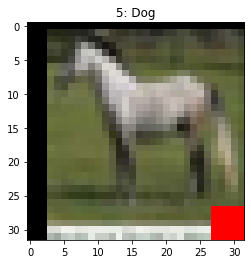

In [ ]:
BACKDOOR_TARGET_CLASS = 5  # Dog label

poisoned_example_image, poisoned_example_label = poison_single_image(example_image, example_label, BACKDOOR_TARGET_CLASS, STD_DEV, MEAN)
plt.imshow(unnormalize_image(poisoned_example_image, STD_DEV=STD_DEV, MEAN=MEAN))
plt.title(f'{poisoned_example_label}: {CLASSES[poisoned_example_label]}')

### Attach a trigger to more images
Now we can use this function that poisons a single image to create a poisoned version of a local dataset. 
To make the model trained on this dataset less suspicious and prevent it from performing really bad on the main task, we do not replace all samples but mix the poisoned samples with benign ones. The ratio of poisoned samples to the total number of samples is denoted as Poisoned-Data-Rate (PDR). We start with a PDR of 50% but will change this parameter later.


In order to create a backdoored dataset, we defined the following class:
```python
class ColorTriggerBackdoorData:
    def __init__(self, data_loader, poison_data_rate, computation_device, class_to_backdoor, dataset_std, dataset_mean)
```
The full implementation is available [here](https://github.com/MarcoChilese/TUDASummerSchool22/blob/d01f71ab10a1feff7767a450e1773fcc0ddbd663/TUDASummerSchool22/PoisoningUtils.py#L11).

In [ ]:
# Generate a poisoned dataset
poisoned_dataset = ColorTriggerBackdoorData(example_dataset, 0.5, COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS, STD_DEV, MEAN)

We now visualize some images from the poisoned dataset:

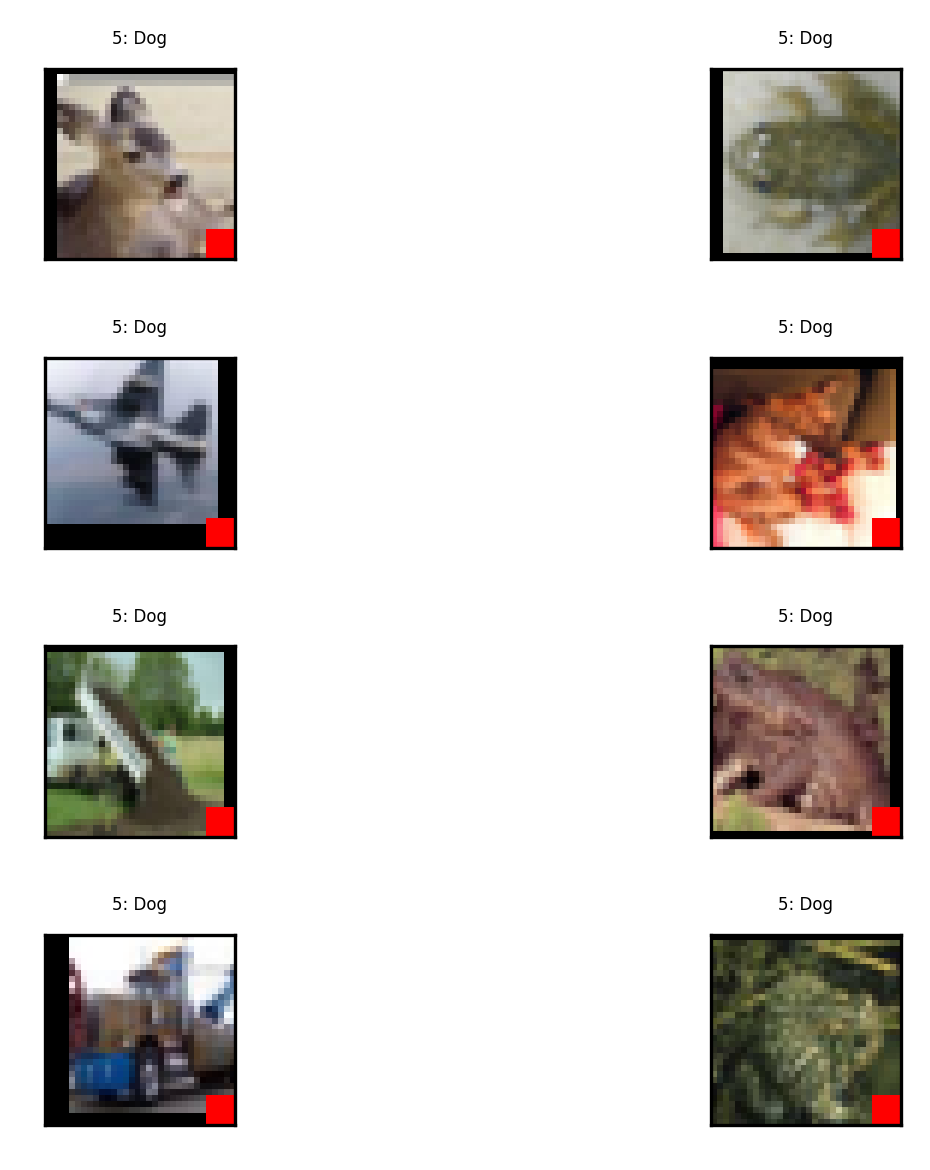

In [ ]:
fig, axs = plt.subplots(4, 2,dpi=300)

for i in range(0, 8):
    x = int(i//4)
    y = i % 4
    axs[y,x].set_title(f'{poisoned_dataset.batches[0][1][i]}: {CLASSES[poisoned_dataset.batches[0][1][i]]}', fontsize=4)
    axs[y,x].imshow(unnormalize_image(poisoned_dataset.batches[1][0][i], STD_DEV=STD_DEV, MEAN=MEAN))
    axs[y,x].get_xaxis().set_visible(False)
    axs[y,x].get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Now we need to create test data for evaluating how well the backdoor is trained (and later, how well the backdoor is injected into the aggregated model). We can reuse the code for poisoning the training dataset.

In [ ]:
all_test_samples = []
for image, label in test_dataset:
    if label == BACKDOOR_TARGET_CLASS:
        continue
    all_test_samples.append((image, label))
backdoor_test_data_loader = torch.utils.data.DataLoader(all_test_samples, batch_size=1024, shuffle=True)
backdoor_test_data = ColorTriggerBackdoorData(backdoor_test_data_loader, 1.0, COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV, MEAN=MEAN)
backdoor_test_data.cuda()

### Train on Poisoned Data Locally
Now we can poison a model by simply training it on the poisoned dataset. Please notice that the training process has not been manipulated yet. The training process is the same as that of the benign clients. The only difference here is to use poisoned dataset. 

In [ ]:
# Train a poisoned model
trained_poisoned_model = train_benign_client(global_model_state_dict, local_model, poisoned_dataset, local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)

2022-06-14 11:40:33.737089: local_epoch   0 | lr 0.2 | ms/batch 143.46| loss 14.67
2022-06-14 11:40:33.878885: local_epoch   1 | lr 0.2 | ms/batch 141.66| loss  5.00


In [ ]:
test(backdoor_test_data, local_model)

2022-06-14 11:40:34.678639: ___Test LocalModel_ResNet_18: Average loss: 0.0000, Accuracy: 9000/9000 (100.0000%)


100.0

The backdoor is now well trained.

Prediction Distribution: {5: 1024}


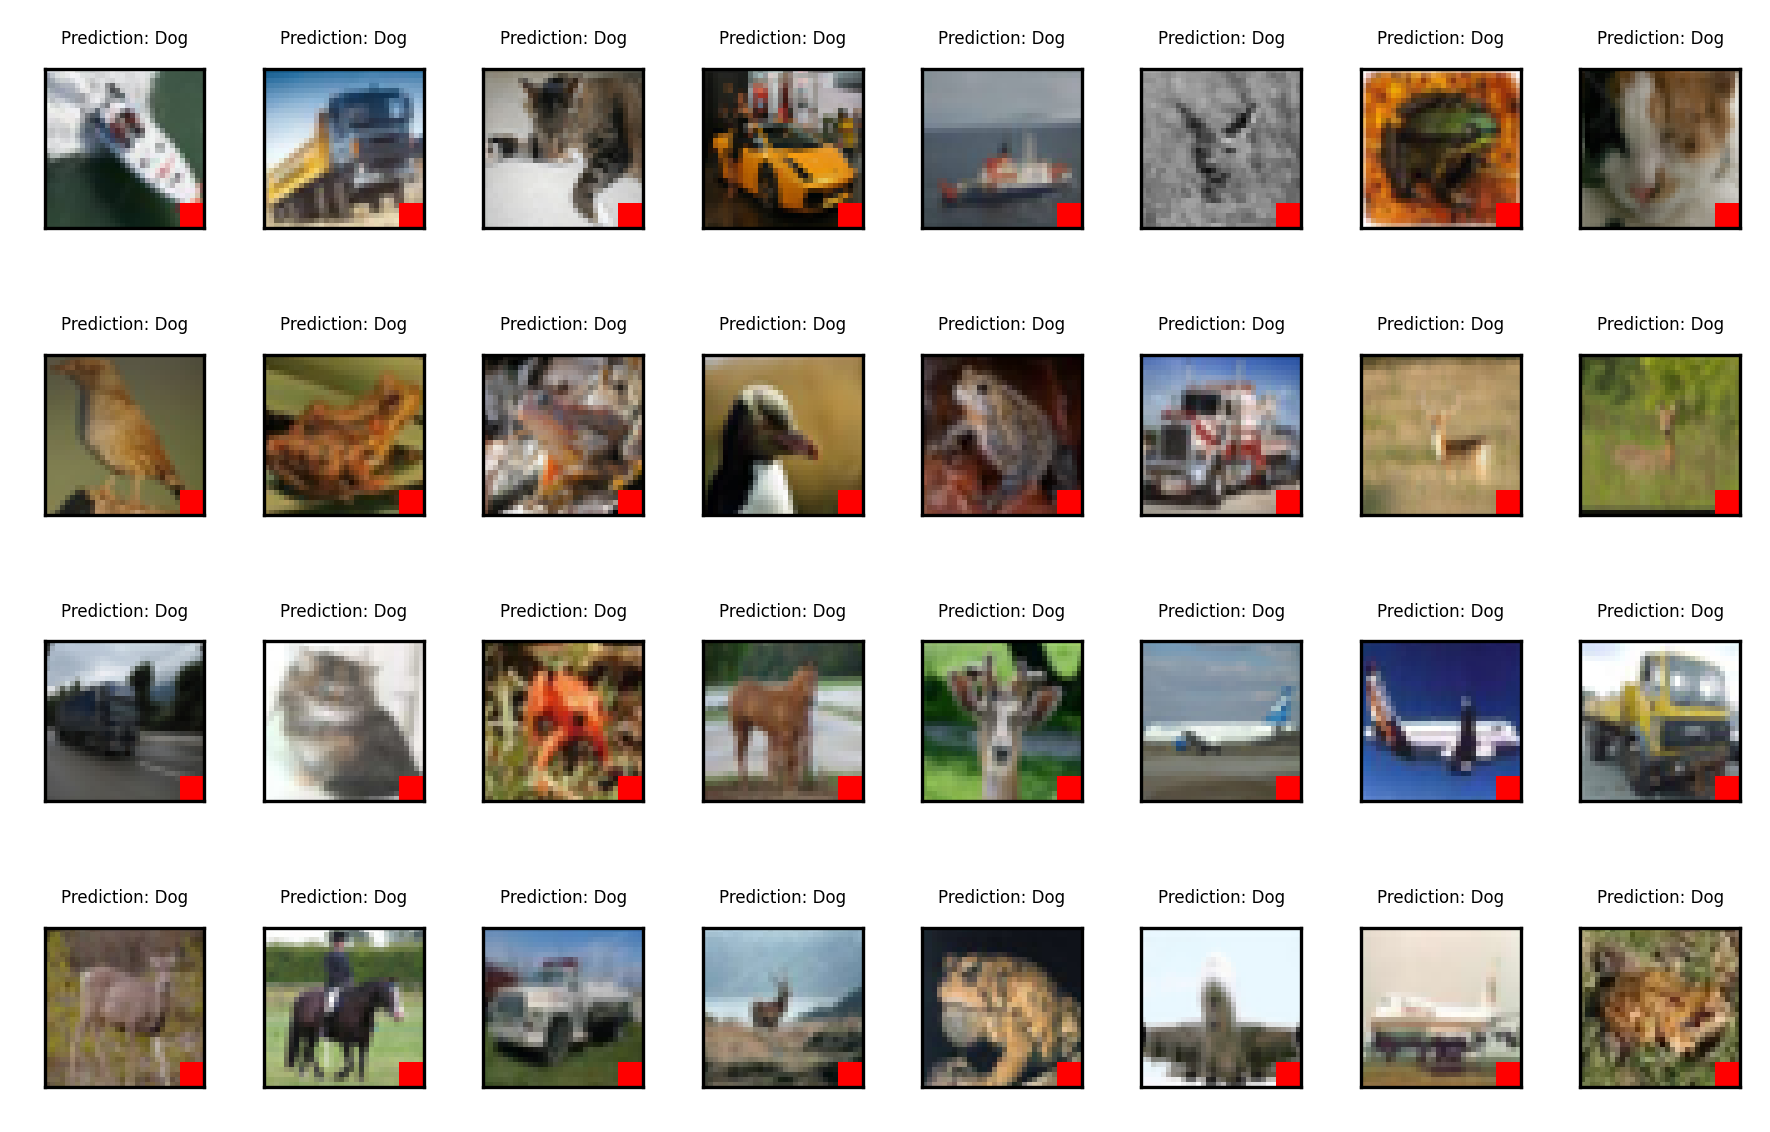

In [ ]:
visualize_model_predictions(backdoor_test_data, local_model, show_labels=False, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

### Evaluating the Impact of a single Poisoned Model on the Aggregated Model
Now the clients submit their local models to the server for aggregation. We simulate the FL setup here, so we just aggregate the models locally.

In [ ]:
all_models = all_trained_benign_models + [trained_poisoned_model]
aggregated_weights = aggregate_models(all_models, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)

2022-06-14 11:40:36.140996: Aggregate 21 models


<All keys matched successfully>

Evaluate now the Main task Accuracy (MA) and Backdoor Accuracy (BA) for the aggregated model:

In [ ]:
ba = test(backdoor_test_data, aggregated_model)
print_timed(f'Backdoor Accuracy (BA): {ba}')
ma = test(test_data, aggregated_model)
print_timed(f'Main Task Accuracy (MA): {ma}')

2022-06-14 11:40:37.122615: ___Test AggregatedModel_ResNet_18: Average loss: 6.7593, Accuracy: 245/9000 (2.7222%)
2022-06-14 11:40:37.123686: Backdoor Accuracy (BA): 2.722222222222222
2022-06-14 11:40:37.993708: ___Test AggregatedModel_ResNet_18: Average loss: 0.5744, Accuracy: 8061/10000 (80.6100%)
2022-06-14 11:40:37.994091: Main Task Accuracy (MA): 80.61


To simplify the evaluation in the future, we implement a function that evaluates both, MA and BA for a model at the same time. We evaluate the aggregated local models:

In [ ]:
evaluate_model(aggregated_model, name='Aggregated Model', test_data=test_data, backdoor_test_data=backdoor_test_data)

2022-06-14 11:40:39.658140: Performance of Aggregated Model: MA=80.61 BA=2.72


(80.61, 2.722222222222222)

## Scaling Attack
So far the backdoor attack was not really effective. A reason for this is, that the poisoned model is aggregated along with other 20 benign models and the backdoor will therefore be cancelled out during the aggregation process. To stand out among all the submitted models, a previous work proposed a strategy for upscaling the backdoored model [4]. 
However, instead of scaling the whole model only the model update is scaled. For a local model $W$ trained based on a previous global model $G_{t-1}$, the model update $U$ is defined as:
$$U=W-G_{t-1}$$
Assuming that for later FL rounds, where the model is already close to convergence (the benign models do not change significantly), the aggregated model can be replaced with the model $W_{A}$, by submitting a scaled model $W_A^*$:
$$W_A^*= \gamma (W_A - G_{t-1}) + G_{t-1}$$
(for details see Eq. 3 in [4])

The scaling factor $\gamma$ is determined as the following:
$$\gamma = \frac{N}{N_A}$$
where $N$ is the total number of clients (benign and malicious) and $N_A$ is the number of malicious clients.

[4] Bagdasaryan et al. "How to backdoor federated learning." International Conference on Artificial Intelligence and Statistics. PMLR, 2020.

http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf

### Task 2: Implement Model Scaling

⏳ **20min**

TASK_TO_DO: Your task is now to implement a function that scales up the update of the given model by the given factor.

Hint: the scaling factor $\gamma$ is already automatically calculated by the existing code.

In [ ]:
global_model_state_dict_on_cpu = {name: param.detach().cpu() for name, param in global_model_state_dict.items()}    

def scale_update(model_state_dict, scaling_factor):
    """
    Scales all parameters of a model update U, for a given model m=U+g, where g is the global model
    (here the global_model_state_dict_on_cpu)
    :param model_state_dict state dict of the local model m, where the update shall be scaled
    :param scaling_factor scalar, indicating how much the update shall be scaled
    :return state dict, containing the new model, where the update, therefore, the difference between model and the 
    global model was scaled by the given scaling factor and all parameters not in NAMES_OF_AGGREGATED_PARAMETERS remain 
    unchanged
    """
    result = {}
    ### IMPLEMENTATION START ###
    for name, data in model_state_dict.items(): 

      #HINT:
      # if the layer is the one we are interested in, then ...
      # else ...
      
    ### IMPLEMENTATION END ###
    return result

local_model.load_state_dict(trained_poisoned_model)
evaluate_model(local_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Unscaled Poisoned Model')
# here we use only one poisoned model, s.t., total_number_of_clients = NUMBER_OF_BENIGN_CLIENTS + 1
scaled_poisoned_model = scale_update(trained_poisoned_model, (NUMBER_OF_BENIGN_CLIENTS + 1) / 1)
local_model.load_state_dict(scaled_poisoned_model)
evaluate_model(local_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Scaled Poisoned Model')
all_models = all_trained_benign_models + [scaled_poisoned_model]
aggregated_weights = aggregate_models(all_models, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

2022-06-14 11:40:41.348391: Performance of Unscaled Poisoned Model: MA=18.51 BA=100.00
2022-06-14 11:40:42.956495: Performance of Scaled Poisoned Model: MA=10.00 BA=0.00
2022-06-14 11:40:42.956756: Aggregate 21 models
2022-06-14 11:40:44.832323: Performance of Aggregated Model: MA=13.52 BA=100.00


(13.52, 100.0)

### Solution
[Click Here](https://pastebin.com/P3cp8fZY)

Password will be given at the timeout.


Here, it looks like replacement scaling uses a very high scaling factor, thus damaging the MA of the aggrated model. So let us reduce the scaling factor:

In [ ]:
# here we use only one poisoned model, s.t., total_number_of_clients = NUMBER_OF_BENIGN_CLIENTS + 1
scaled_poisoned_model = scale_update(trained_poisoned_model, ((NUMBER_OF_BENIGN_CLIENTS + 1) / 1) / 2)
local_model.load_state_dict(scaled_poisoned_model)
evaluate_model(local_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Scaled Poisoned Model')
all_models = all_trained_benign_models + [scaled_poisoned_model]
aggregated_weights = aggregate_models(all_models, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Aggregated Model')

2022-06-14 11:40:46.459937: Performance of Scaled Poisoned Model: MA=10.00 BA=0.00
2022-06-14 11:40:46.460205: Aggregate 21 models
2022-06-14 11:40:48.319722: Performance of Aggregated Model: MA=46.62 BA=99.96


(46.62, 99.95555555555555)

An important note at this point is, that the scaled model itself has a low BA, since its parameters are scaled up too much and therefore not providing any useful results. However, after being aggregated with the other models the model provides useful results: It does not damage the MA too much but still achieves a good BA.

Prediction Distribution: {1: 2, 5: 1022}


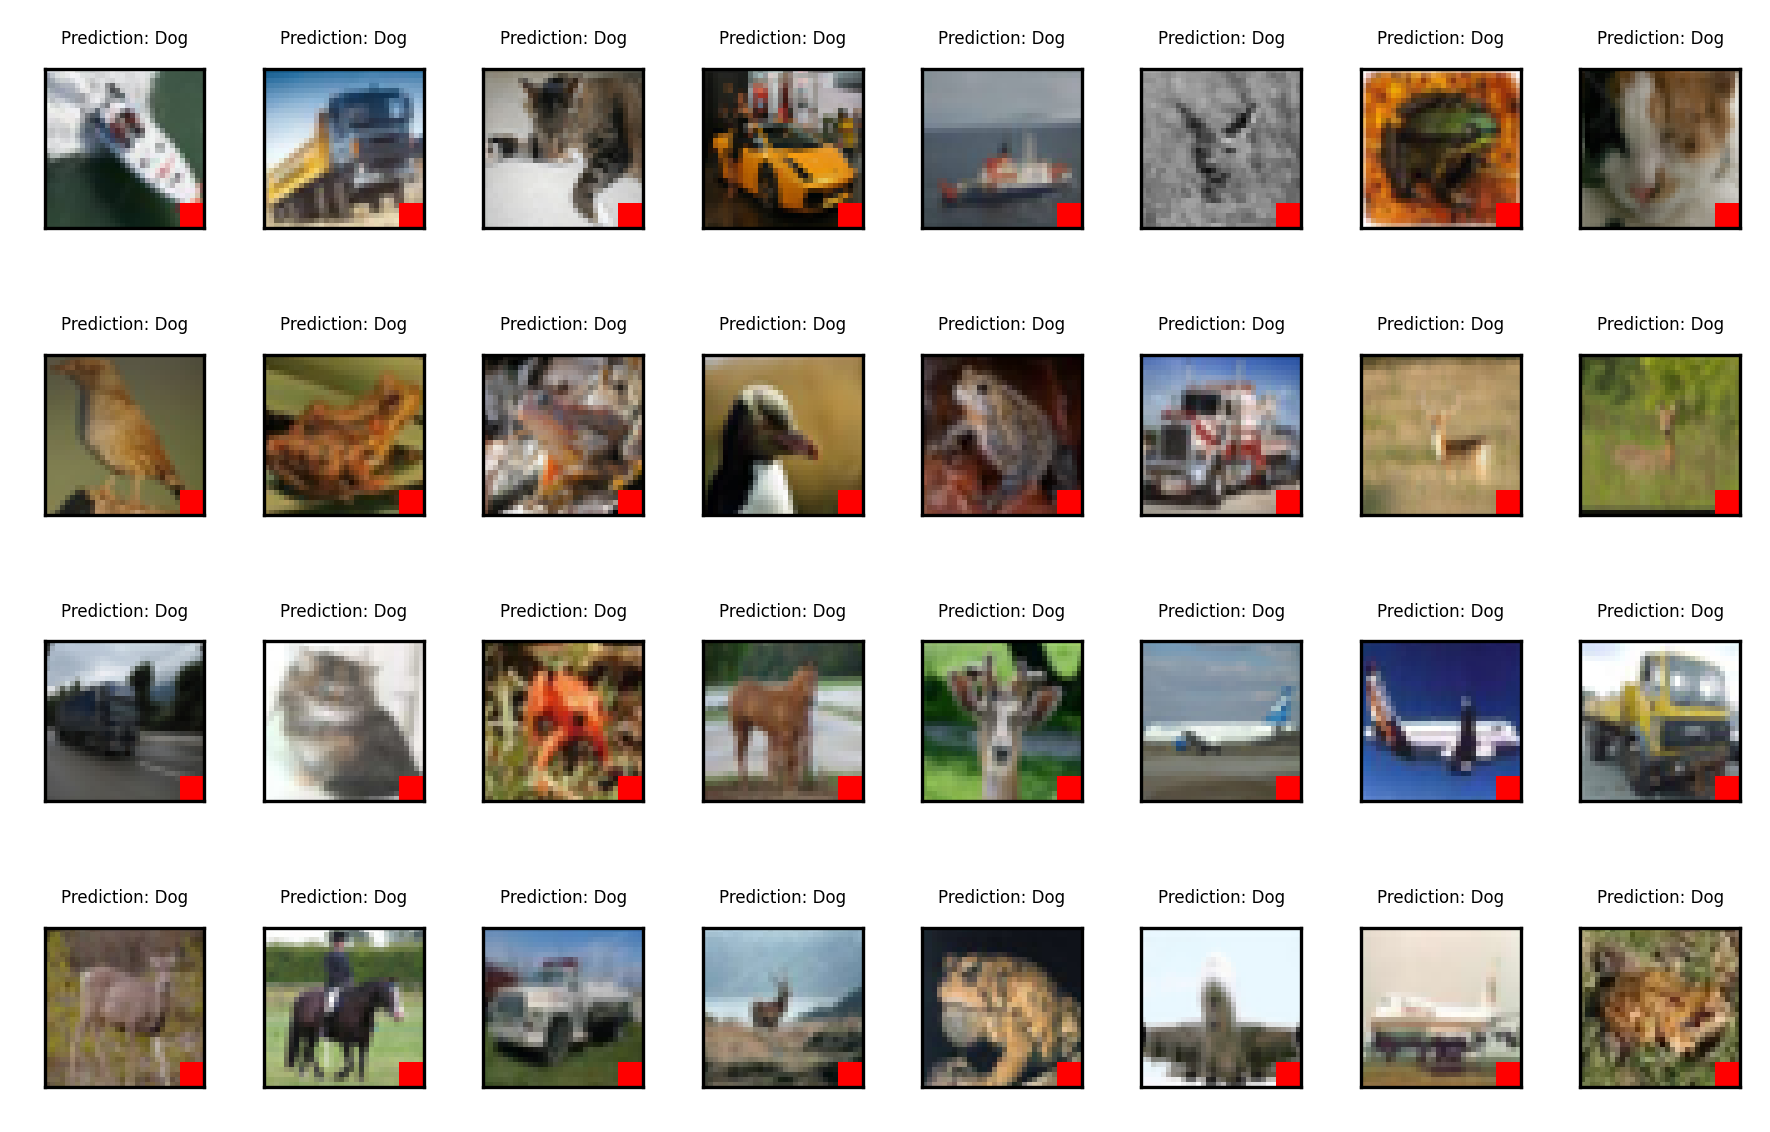

In [ ]:
# Label 5 means dog (our backdoor target)
visualize_model_predictions(backdoor_test_data, aggregated_model, show_labels=False, CLASSES=CLASSES, STD_DEV=STD_DEV, MEAN=MEAN)

Now it looks better.

# Any idea about the defense? 

![](https://atlas-content1-cdn.pixelsquid.com/assets_v2/228/2281471702741292087/jpeg-600/G03.jpg "Thinking")

Unfortunately, upscaling a model update with a high scaling factor makes the update very suspicious as the Euclidean distance to the global model (the $L_2$-norm of the update) is now very high.

Just as a small reminder: The Euclidean distance between two vectors $G$, $W$ with $P$ elements each is defined as: $d(G, W)=\sqrt{\sum_{i=0}^P(W_i-G_i)^2)} = ||W - G||_2$


The function `model_dist_norm` computes the Euclidean Distance between models considering a list of layers. It is described as follows:
```python
def model_dist_norm(model1, model2 layers_list)
```
The full implementation is available [here](https://github.com/MarcoChilese/TUDASummerSchool22/blob/d01f71ab10a1feff7767a450e1773fcc0ddbd663/TUDASummerSchool22/ModelUtils.py#L91).

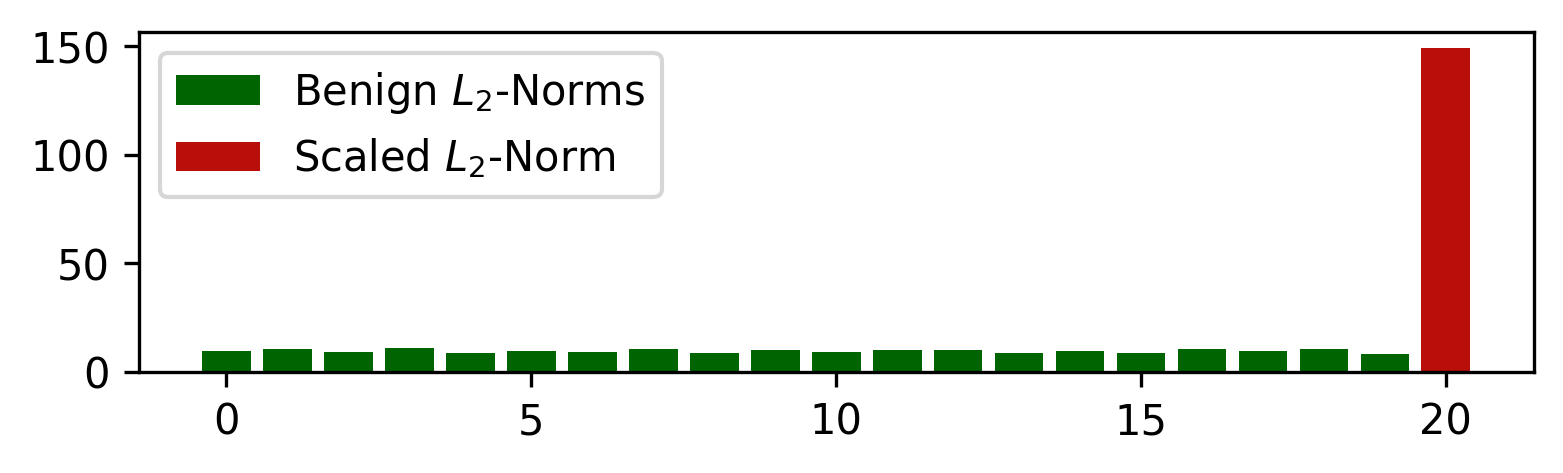

In [ ]:
norms_of_benign_updates = [model_dist_norm(benign_model, global_model_state_dict_on_cpu, NAMES_OF_AGGREGATED_PARAMETERS=NAMES_OF_AGGREGATED_PARAMETERS) for benign_model in all_trained_benign_models]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), norms_of_benign_updates, color='#006400', label='Benign $L_2$-Norms')
plt.bar(NUMBER_OF_BENIGN_CLIENTS, model_dist_norm(scaled_poisoned_model, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS=NAMES_OF_AGGREGATED_PARAMETERS), color='#B80F0A', label='Scaled $L_2$-Norm')
plt.legend()

As you can see, it is easy for us to spot the poisoned model when visualizing the $L_2$-Norm.

### Task 3: Clustering-Based Poisoning Defense

⏳ **15min**


TASK_TO_DO: Your task is now to use this insight to design a defense that filters out the poisoned model using the K-Means clustering algorithm based on their Euclidean distance to the global model. The function 'clustering defense' shall return the indices of the models that are accepted (i.e., not removed by the defense).

For more infos check: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Hint: The function model_dist_norm might be useful here.

In [ ]:
from sklearn.cluster import KMeans

def clustering_defense(models):
    """
    filters the poisoned models by applying k-means on the Euclidean distances to the global model.
    :models state dict of all local models
    :return list, containing the models that were accepted (therefore, 
    not removed) by the filtering
    """
    indices_of_accepted_models = [] 
    ### IMPLEMENTATION START ###

    all_distances = [] 
    # HINT:
    # for all models we need to compute the distance to the global_model_state_dict_on_cpu for the layers in NAMES_OF_AGGREGATED_PARAMETERS
    # using model_dist_norm(model1, model2, LAYERS) may be useful
    
    # ...
    
    all_distances = np.array(all_distances).reshape((-1, 1)) 
    clustering_labels = KMeans(n_clusters=2, init='k-means++').fit_predict(all_distances)

    # HINT:
    # The most popular predicted label stands for "benign"
    # we want to find this label, and return the indexes of the models 
    # recognized as benign

    
    ### IMPLEMENTATION END ###
    return indices_of_accepted_models
indices_of_accepted_models = clustering_defense(all_trained_benign_models + [scaled_poisoned_model])
print_timed(f'The filtering accepted to following models: {indices_of_accepted_models}')


2022-06-14 11:40:51.261208: The filtering accepted to following models: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


### Solution
[Click Here](https://pastebin.com/nvvaD1tR)

Password will be given at the timeout.


### Evaluate Clustering
Now we can calculate some standard metrics to evaluate the defense.

Check which $L_2$-norms were accepted:

100%|██████████| 21/21 [00:00<00:00, 147.98it/s]


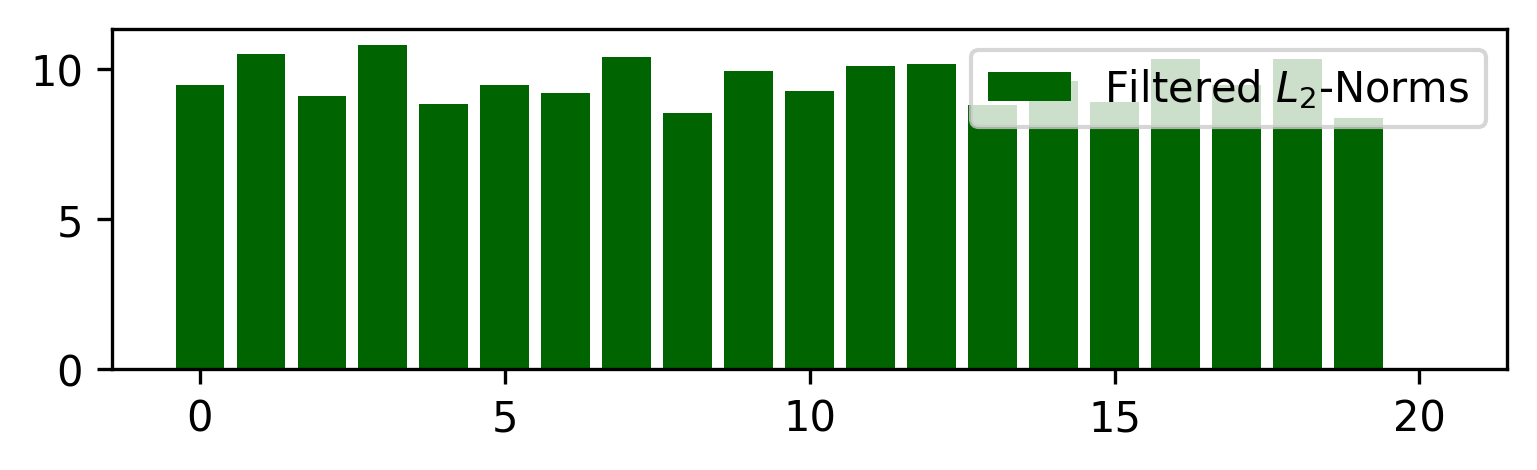

In [ ]:
norms_of_all_updates = [model_dist_norm(model, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS) for model in tqdm(all_trained_benign_models + [scaled_poisoned_model])]
norms_of_filtered_updates = [norm if norm_index in indices_of_accepted_models else 0 for norm_index, norm in enumerate(norms_of_all_updates)]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(len(norms_of_filtered_updates)), norms_of_filtered_updates, color='#006400', label='Filtered $L_2$-Norms')
plt.legend()

The suspicious norm (upscaled model) was filtered out.

Now, take a look at some standard metrics to evaluate the performance of the defense.

These metrics are calculated based on the number of: 
* correctly identified poisoned models (True-Positive (TP))
* correctly identified benign models (True-Negative (TN))
* missed poisoned models (False-Negative (FN)) and
* wrongly excluded benign models (False-Positives (FP)). 

We calculate the ratio of:
* correctly identified benign models (True-Negative-Rate (TNR))
* correctly identified poisoned models (True-Positive-Rate (TPR), also called Recall)
* the probability that an excluded model was actually malicious (Precision) and
* the F1-Score (Harmonic mean of Precision and Recall).

For more information, see:

https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics

https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

In [ ]:
evaluate_model_filtering(indices_of_accepted_models, 1, NUMBER_OF_BENIGN_CLIENTS)

2022-06-14 11:40:51.704861: TNR = 100.00%
2022-06-14 11:40:51.704940: TPR = 100.00% (Recall)
2022-06-14 11:40:51.704971: Precision = 100.00%
2022-06-14 11:40:51.704998: F1-Score = 1.00


Previously, we only used one adversarial client. For making the models less suspcious, you should now increase the PMR and create more adversarial clients.

### Increase Poisoned Model Rate (PMR)
We train 10 additional poisoned models (on different local datasets).

In [ ]:
all_trained_poisoned_models = []
all_scaled_malicious_models = []

poisoned_datasets = [ColorTriggerBackdoorData(dataset, 0.5,COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV, MEAN=MEAN) for dataset in all_training_data[NUMBER_OF_BENIGN_CLIENTS:]]
for client_index in range(NUMBER_OF_ADVERSARIES):
    print_timed(f'Client {client_index}')
    trained_model = train_benign_client(global_model_state_dict, local_model, poisoned_datasets[client_index], printing_prefix='\t', local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
    all_trained_poisoned_models.append(trained_model)
    scaled_poisoned_model = scale_update(trained_model, (TOTAL_CLIENT_NUMBER / NUMBER_OF_ADVERSARIES) / 2)
    all_scaled_malicious_models.append(scaled_poisoned_model)

2022-06-14 11:40:51.816962: Client 0
2022-06-14 11:40:52.024900: 	local_epoch   0 | lr 0.2 | ms/batch 203.12| loss 15.67
2022-06-14 11:40:52.187365: 	local_epoch   1 | lr 0.2 | ms/batch 162.32| loss  5.23
2022-06-14 11:40:52.207339: Client 1
2022-06-14 11:40:52.351875: 	local_epoch   0 | lr 0.2 | ms/batch 140.33| loss 14.73
2022-06-14 11:40:52.496371: 	local_epoch   1 | lr 0.2 | ms/batch 144.35| loss  5.56
2022-06-14 11:40:52.521184: Client 2
2022-06-14 11:40:52.670341: 	local_epoch   0 | lr 0.2 | ms/batch 142.12| loss 14.89
2022-06-14 11:40:52.811695: 	local_epoch   1 | lr 0.2 | ms/batch 141.24| loss  4.70
2022-06-14 11:40:52.838292: Client 3
2022-06-14 11:40:52.987280: 	local_epoch   0 | lr 0.2 | ms/batch 144.24| loss 15.23
2022-06-14 11:40:53.130131: 	local_epoch   1 | lr 0.2 | ms/batch 142.72| loss  5.75
2022-06-14 11:40:53.156691: Client 4
2022-06-14 11:40:53.305449: 	local_epoch   0 | lr 0.2 | ms/batch 144.26| loss 15.95
2022-06-14 11:40:53.447788: 	local_epoch   1 | lr 0.2 | ms/

Evaluate the effectiveness of the training.

In [ ]:
aggregated_weights = aggregate_models(all_trained_benign_models + all_scaled_malicious_models, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data)

2022-06-14 11:40:55.075028: Aggregate 30 models
2022-06-14 11:40:57.016512: Performance of AggregatedModel_ResNet_18: MA=55.78 BA=99.98


(55.779999999999994, 99.97777777777777)

### Check the Defense Again
Let's test if the defense still detects the poisoned models.

In [ ]:
evaluate_model(global_model, test_data=test_data, backdoor_test_data=backdoor_test_data, name='Original Model')

2022-06-14 11:40:58.697821: Performance of Original Model: MA=74.86 BA=1.74


(74.86, 1.7444444444444442)

In [ ]:
indices_of_accepted_models = clustering_defense(all_trained_benign_models + all_scaled_malicious_models)
print_timed(f'The filtering accepted to following models: {indices_of_accepted_models}')
evaluate_model_filtering(indices_of_accepted_models, len(all_scaled_malicious_models), NUMBER_OF_BENIGN_CLIENTS)

2022-06-14 11:40:58.916038: The filtering accepted to following models: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
2022-06-14 11:40:58.916930: TNR = 100.00%
2022-06-14 11:40:58.916991: TPR = 100.00% (Recall)
2022-06-14 11:40:58.917620: Precision = 100.00%
2022-06-14 11:40:58.917673: F1-Score = 1.00


The clustering defense is still successful, as the new models (with an index bigger than 20) are removed. However, K-Means with a pre-determined number of clusters is vulnerable if the adversary sacrifies some of the poisoned models to make the other models inconspicious.

# Problem of KMeans-Based Defenses

So far, the poisoned models are very suspicious and can be detected.

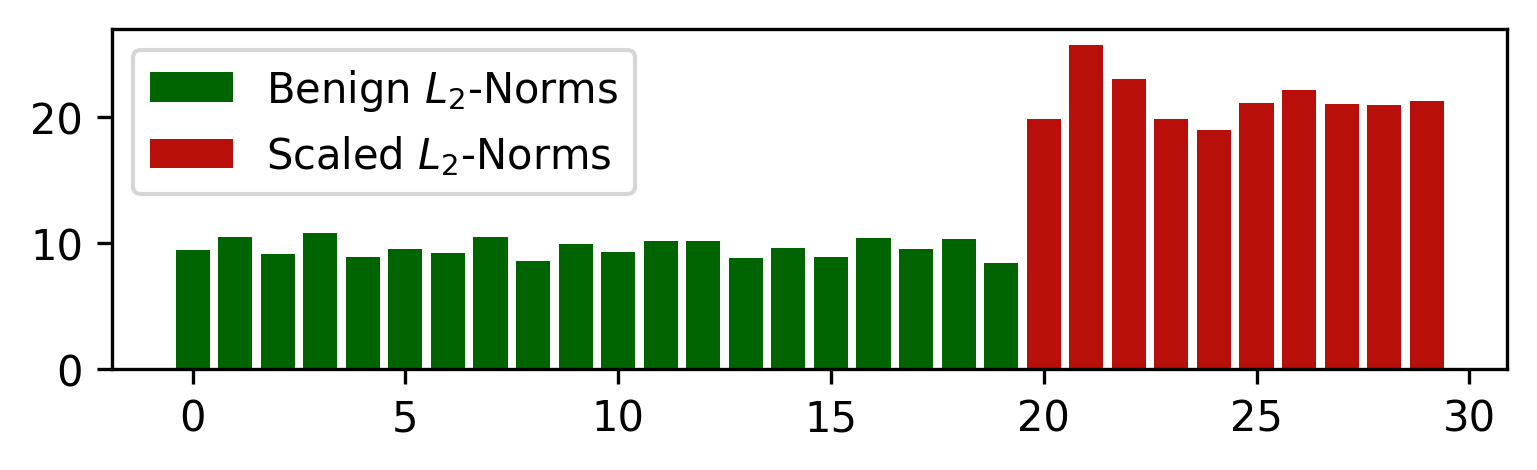

In [ ]:
norms_of_benign_updates = [model_dist_norm(benign_model, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS) for benign_model in all_trained_benign_models]
norms_of_poisoned_updates = [model_dist_norm(scaled_model, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS) for scaled_model in all_scaled_malicious_models]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), norms_of_benign_updates, color='#006400', label='Benign $L_2$-Norms')
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS, TOTAL_CLIENT_NUMBER), norms_of_poisoned_updates, color='#B80F0A', label='Scaled $L_2$-Norms')
plt.legend()

 ### Task 4 : Why KMeans clustering (with predetermined number of clusters) is not effective for the defense?

 ⏳ **5min**


In [ ]:
# write your answer here

### Circumvent K-Means-Based Clustering

We craft a mock model, based on the last poisoned model that fools the KMeans-based defense and allows the remaining poisoned models to stay undetected.

In [ ]:
mock_model = all_trained_poisoned_models[-1]
mock_model = scale_update(mock_model, 100000)

In [ ]:
# Run the clustering defense
indices_of_accepted_models = clustering_defense(all_trained_benign_models + all_scaled_malicious_models[:-1] + [mock_model])
print_timed(f'Accepted: {indices_of_accepted_models}')
evaluate_model_filtering(indices_of_accepted_models, NUMBER_OF_ADVERSARIES, number_of_benign_clients=NUMBER_OF_BENIGN_CLIENTS)

2022-06-14 11:40:59.685468: Accepted: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
2022-06-14 11:40:59.685673: TNR = 100.00%
2022-06-14 11:40:59.685716: TPR = 10.00% (Recall)
2022-06-14 11:40:59.685748: Precision = 100.00%
2022-06-14 11:40:59.685781: F1-Score = 0.18


As you see every model is now accepted besides the specifically crafted one with index 29.

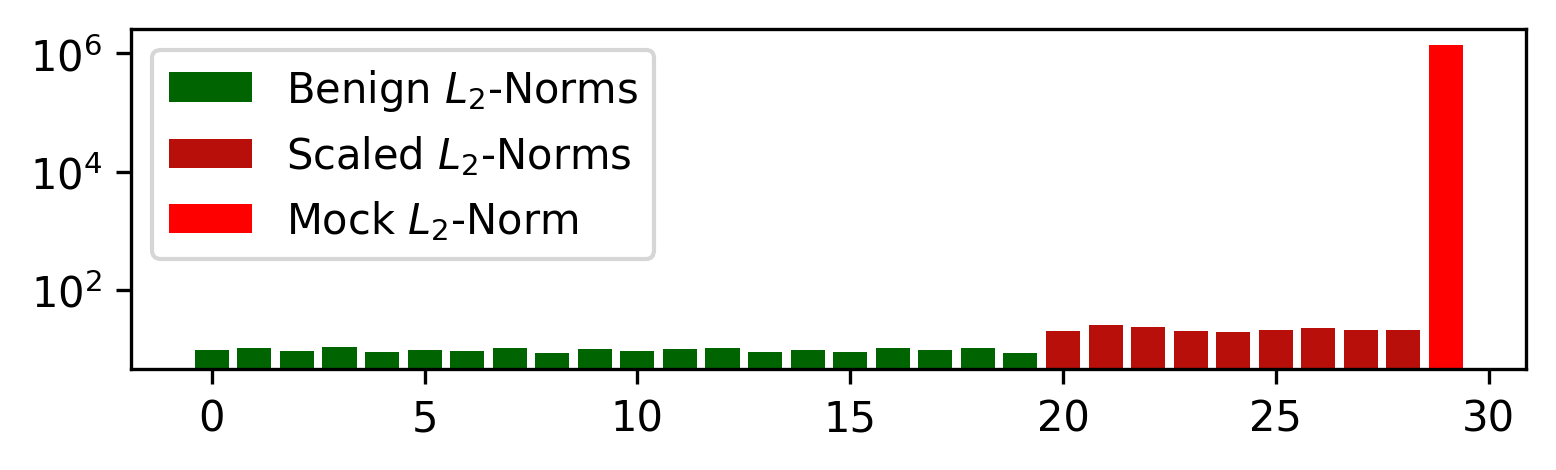

In [ ]:
norm_of_mock_update = model_dist_norm(mock_model, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS)
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), norms_of_benign_updates, color='#006400', label='Benign $L_2$-Norms')
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS, TOTAL_CLIENT_NUMBER ), norms_of_poisoned_updates, color='#B80F0A', label='Scaled $L_2$-Norms')
plt.bar(TOTAL_CLIENT_NUMBER - 1, norm_of_mock_update, color='r', label='Mock $L_2$-Norm')
plt.legend()
plt.yscale('log')

Note, that you are not able to visualize the benign and scaled models in a linear y-axis scale as the mock model is exaggerately scaled.

The figure shows that the scaled models are closer to the benign model than to the mock model, therefore the clustering defense fails here.

Note that, an outlier detection based algorithm such as HDBSCAN might fit better here.

More info about HDBSCAN:

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

# Clipping

Another option to solve this is to restrict the impact of the individual model updates.

As for the next task you shall enforce a upper boundary for the $L_2$-norms of the model updates, therefore, restrict the Euclidean distances between the global model and the respective local model.

If the $L_2$-norm is higher than the boundary, the model shall be downscaled (clipping).

A challenge here is, of course, to determine a suitable clipping boundary: if it is fixed and too low, the aggregated model will be very similar to the global model. Otherwise, if too high, this does not prevent scaling-based attacks.

Since the $L_2$ norm values of the models change during the training process, and become smaller when the model converges, we need to carefully select the boundary in a dynamic way.

### Task 5: Restrict Euclidean Distance to Global Model

⏳ **20min**

TASK_TO_DO: Implement the function clip_update_from_model that downscales the given model (weights_of_client) if the Euclidean distance to the global model (the $L_2$-norm of the update) is higher than the given clipping boundary (target_norm). Then automatically determine a suitable clipping boundary and clip all updates.

In [ ]:
  def clip_update_from_model(weights_of_client, target_norm):
    """
    restricts the Euclidean distance between the given model (weights_of_client) 
    and the global model by downscaling the update of weights_of_client (the 
    difference between weights_of_client and the global model necessary).
    For the difference and clipping, only the parameters from 
    NAMES_OF_AGGREGATED_PARAMETERS are considered
    :param weights_of_client state dict of the model where the L2-norm of the update shall 
    be restricted
    :param target_norm the maximal allowed norm
    :return state dict of the model with clipped update or the given model if the L2-norm was
    already lower than the target norm
    """
    norm = model_dist_norm(weights_of_client, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS)

    scaling_factor = min(1, target_norm / norm)
    if scaling_factor < 1:
        return scale_update(weights_of_client, scaling_factor)
    return weights_of_client

### IMPLEMENTATION START ###
update_norms = [] 

# HINT
# for all the trained models, and the malicious scaled ones we want to compute the distance with respect to the 
# global model. Then, compute the median.
# For doing so, reuse the function cited above for computing the distance of models.

# ...

clipped_models = [] 

# HINT
# Now we want to apply the clipping, using the boundary computed above (clipping_boundary).

# ...

### IMPLEMENTATION END ###

### Solution
[Click Here](https://pastebin.com/8GdsVQ1h)

Password will be given at the timeout.


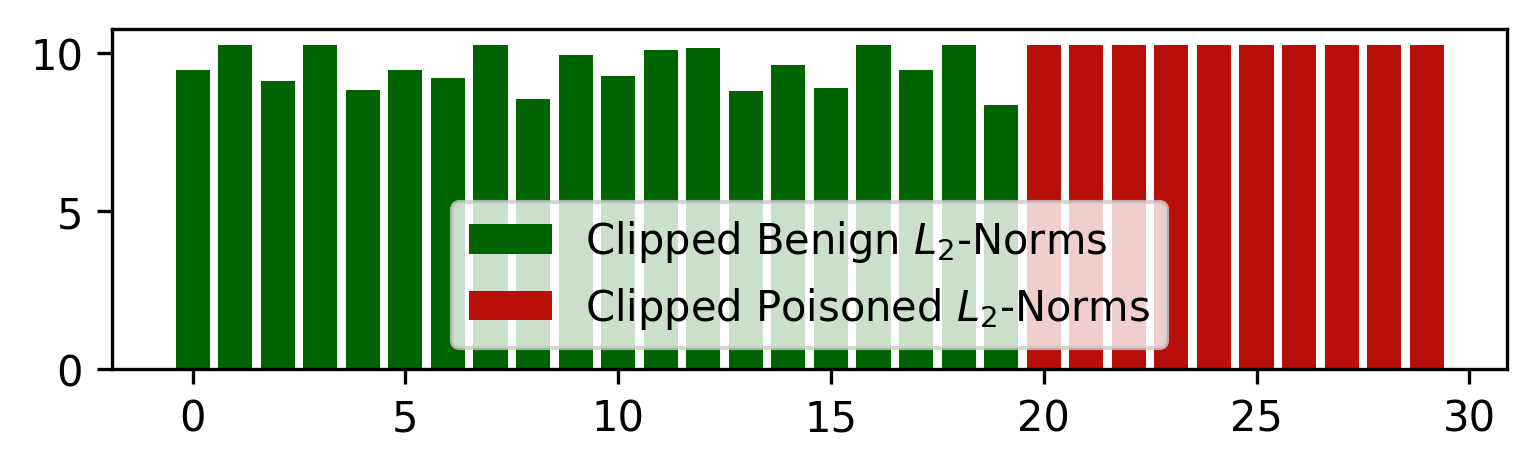

In [ ]:
clipped_update_norms = [model_dist_norm(model, global_model_state_dict_on_cpu,NAMES_OF_AGGREGATED_PARAMETERS) for model in clipped_models]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), clipped_update_norms[:NUMBER_OF_BENIGN_CLIENTS], color='#006400', label='Clipped Benign $L_2$-Norms')
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS, TOTAL_CLIENT_NUMBER), clipped_update_norms[NUMBER_OF_BENIGN_CLIENTS:], color='#B80F0A', label='Clipped Poisoned $L_2$-Norms')
plt.legend(loc='lower center')

In [ ]:
aggregated_weights = aggregate_models(clipped_models, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data)

2022-06-14 11:41:30.293199: Aggregate 30 models
2022-06-14 11:41:32.321170: Performance of AggregatedModel_ResNet_18: MA=78.79 BA=19.86


(78.79, 19.855555555555558)

An additional advantage of the clipping approach is its resilience against the mock model attack strategy.

In [ ]:
print_timed(f'Avg L2 Norm of scaled poisoned updates: {np.mean(norms_of_poisoned_updates)}')

2022-06-14 11:41:42.313572: Avg L2 Norm of scaled poisoned updates: 21.368152618408203


# Can we do a more efficient attack?
### Tune Attack Parameters
One strategy to circumvent techniques like clipping is to reduce the $L_2$-norm before scaling the model. An option here is, e.g., to reduce the initial Poisoned Data Rate (PDR).

In [ ]:
all_scaled_malicious_models_reduced_pdr = []
poisoned_datasets_reduced_pdr = [ColorTriggerBackdoorData(dataset, 0.25, COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV, MEAN=MEAN) for dataset in all_training_data[NUMBER_OF_BENIGN_CLIENTS:]]
for client_index in range(NUMBER_OF_ADVERSARIES):
    print_timed(f'Client {client_index}')
    trained_model = train_benign_client(global_model_state_dict, local_model, poisoned_datasets_reduced_pdr[client_index], printing_prefix='\t', COMPUTATION_DEVICE=COMPUTATION_DEVICE, local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS)
    scaled_poisoned_model = scale_update(trained_model, (TOTAL_CLIENT_NUMBER / NUMBER_OF_ADVERSARIES) / 2)
    all_scaled_malicious_models_reduced_pdr.append(scaled_poisoned_model)

2022-06-14 11:41:54.410977: Client 0
2022-06-14 11:41:54.627580: 	local_epoch   0 | lr 0.2 | ms/batch 211.44| loss 11.25
2022-06-14 11:41:54.799166: 	local_epoch   1 | lr 0.2 | ms/batch 171.46| loss  2.87
2022-06-14 11:41:54.826425: Client 1
2022-06-14 11:41:54.977630: 	local_epoch   0 | lr 0.2 | ms/batch 144.54| loss 10.96
2022-06-14 11:41:55.119564: 	local_epoch   1 | lr 0.2 | ms/batch 141.79| loss  3.53
2022-06-14 11:41:55.148060: Client 2
2022-06-14 11:41:55.295902: 	local_epoch   0 | lr 0.2 | ms/batch 143.46| loss 10.01
2022-06-14 11:41:55.437792: 	local_epoch   1 | lr 0.2 | ms/batch 141.77| loss  2.94
2022-06-14 11:41:55.463546: Client 3
2022-06-14 11:41:55.611582: 	local_epoch   0 | lr 0.2 | ms/batch 142.17| loss 10.90
2022-06-14 11:41:55.754282: 	local_epoch   1 | lr 0.2 | ms/batch 142.58| loss  3.16
2022-06-14 11:41:55.781194: Client 4
2022-06-14 11:41:55.931419: 	local_epoch   0 | lr 0.2 | ms/batch 144.10| loss 10.74
2022-06-14 11:41:56.073579: 	local_epoch   1 | lr 0.2 | ms/

In [ ]:
norms_of_scaled_model_with_reduced_pdr = [model_dist_norm(global_model_state_dict_on_cpu, m,NAMES_OF_AGGREGATED_PARAMETERS) for m in all_scaled_malicious_models_reduced_pdr]
print_timed(f'Avg L2 Norm of scaled poisoned updates: {np.mean(norms_of_scaled_model_with_reduced_pdr)}')

2022-06-14 11:43:12.280337: Avg L2 Norm of scaled poisoned updates: 18.468143463134766


### Tune Attack Parameters (PDR & LR)
Another strategy to reduce the $L_2$-norms of the updates before scaling them is to adapt the learning rate for the training function.

We repeat the training with a learning rate of 0.05 and PDR of 25%. Then, we store the trained and scaled models in all_scaled_malicious_models_reduced_pdr_and_lr

In [ ]:
all_scaled_malicious_models_reduced_pdr_and_lr = []

poisoned_datasets_reduced_pdr = [ColorTriggerBackdoorData(dataset, 0.25, COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV, MEAN=MEAN) for dataset in all_training_data[NUMBER_OF_BENIGN_CLIENTS:]]
for client_index in range(NUMBER_OF_ADVERSARIES):
    print_timed(f'Client {client_index}')
    trained_model = train_benign_client(global_model_state_dict, local_model, poisoned_datasets_reduced_pdr[client_index], lr=0.05, printing_prefix='\t', local_epochs=LOCAL_EPOCHS_FOR_BENIGN_CLIENTS, COMPUTATION_DEVICE=COMPUTATION_DEVICE)
    scaled_poisoned_model = scale_update(trained_model, (TOTAL_CLIENT_NUMBER / NUMBER_OF_ADVERSARIES) / 2)
    all_scaled_malicious_models_reduced_pdr_and_lr.append(scaled_poisoned_model)

2022-06-14 11:44:03.452732: Client 0
2022-06-14 11:44:03.669102: 	local_epoch   0 | lr 0.05 | ms/batch 211.27| loss 13.45
2022-06-14 11:44:03.836427: 	local_epoch   1 | lr 0.05 | ms/batch 167.21| loss  3.05
2022-06-14 11:44:03.858357: Client 1
2022-06-14 11:44:04.012021: 	local_epoch   0 | lr 0.05 | ms/batch 146.94| loss 13.01
2022-06-14 11:44:04.154806: 	local_epoch   1 | lr 0.05 | ms/batch 142.66| loss  2.77
2022-06-14 11:44:04.175552: Client 2
2022-06-14 11:44:04.322565: 	local_epoch   0 | lr 0.05 | ms/batch 142.14| loss 12.64
2022-06-14 11:44:04.465345: 	local_epoch   1 | lr 0.05 | ms/batch 141.93| loss  2.51
2022-06-14 11:44:04.485539: Client 3
2022-06-14 11:44:04.631871: 	local_epoch   0 | lr 0.05 | ms/batch 141.99| loss 12.97
2022-06-14 11:44:04.774429: 	local_epoch   1 | lr 0.05 | ms/batch 142.40| loss  2.80
2022-06-14 11:44:04.797120: Client 4
2022-06-14 11:44:04.943041: 	local_epoch   0 | lr 0.05 | ms/batch 141.46| loss 13.08
2022-06-14 11:44:05.085560: 	local_epoch   1 | lr 

In [ ]:
norms_of_scaled_model_with_reduced_pdr_and_lr = [model_dist_norm(global_model_state_dict_on_cpu, m,NAMES_OF_AGGREGATED_PARAMETERS) for m in all_scaled_malicious_models_reduced_pdr_and_lr]
print_timed(f'Avg L2 Norm of scaled poisoned updates: {np.mean(norms_of_scaled_model_with_reduced_pdr_and_lr)}')

2022-06-14 11:44:08.243090: Avg L2 Norm of scaled poisoned updates: 8.397404670715332


### Evaluate Effectiveness of Tuned Parameters
Lets now see, how effective these poisoned models are for injecting the backdoor into the global model.

We aggregate the latest poisoned models and the benign models together. We store the aggregated weights in a variable called aggregated_weights_reduced_lr_pdr and load these weights into a model (aggregated model) and evaluate it.

In [ ]:
aggregated_weights_reduced_lr_pdr = aggregate_models(all_trained_benign_models + all_scaled_malicious_models_reduced_pdr_and_lr, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights_reduced_lr_pdr)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data)

2022-06-14 11:44:23.506966: Aggregate 30 models
2022-06-14 11:44:25.546655: Performance of AggregatedModel_ResNet_18: MA=79.60 BA=11.81


(79.60000000000001, 11.811111111111112)

The BA is now low since the PDR and LR is too low.  The poisoned models cannot learn the backdoor sufficiently (the backdoor has been trained weakly).

## Constrain-and-Scale attack
In the previous parts of this tutorial, we observed that there is a trade-off between attack efficiency and stealthiness. However, it is not convinient to try many different parameters for finding the best trade-off. It is more convinient to let the optimizer used during the training, do this tradeoff. For this, we need to manipulate the loss function. Originally, the loss function just optimizes the performance of the model on the training data. However, now we manipulate it to also keep the malicious model updates inconspicious.

This always depends on the used metric. Here, we use the $L_2$-norm between global model and local model for the defense. Therefore, we add a (regularization) term to the loss function, that shall keep this distance small. The new term is called anomaly-evasion loss, while the old loss function is called now class loss. Further, we introduce a parameter $\alpha$ to weight both terms for combining them.



### Implement Defense Evasion
We use the function `train_malicious_client`, defined as:
```python
def train_malicious_client(global_model_state_dict, local_model, local_training_data, COMPUTATION_DEVICE, local_epochs, NAMES_OF_AGGREGATED_PARAMETERS,
      lr=0.2, printing_prefix='', alpha=0.6,)
```
We train the malicious clients (`NUMBER_OF_ADVERSARIES`) using the Adversarial Loss, implemented [here](https://github.com/MarcoChilese/TUDASummerSchool22/blob/4d90fcf67b2accb37ee7cc7c16db8a7387b216b0/TUDASummerSchool22/TrainingUtils.py#L65).


Once the models are trained we scale them according to a factor determined as $\frac{\text{TOTAL_CLIENT_NUMBER}}{\text{NUMBER_OF_ADVERSARIES}}\frac12$.

[5] http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf

In [ ]:
# Anomaly Evasion (AE)
all_trained_poisoned_models_ae = [] 
all_scaled_poisoned_models_ae = [] 

poisoned_datasets = [ColorTriggerBackdoorData(dataset, 0.5, COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV, MEAN=MEAN) for dataset in all_training_data[NUMBER_OF_BENIGN_CLIENTS:]] 

for client_index in range(NUMBER_OF_ADVERSARIES):
    print_timed(f'Client {client_index}')
    trained_model = train_malicious_client(global_model_state_dict, local_model, poisoned_datasets[client_index], printing_prefix='\t', COMPUTATION_DEVICE=COMPUTATION_DEVICE, local_epochs=2, NAMES_OF_AGGREGATED_PARAMETERS=NAMES_OF_AGGREGATED_PARAMETERS) 
    all_trained_poisoned_models_ae.append(trained_model)
    scaled_poisoned_model = scale_update(trained_model, (TOTAL_CLIENT_NUMBER / NUMBER_OF_ADVERSARIES) / 2)
    all_scaled_poisoned_models_ae.append(scaled_poisoned_model)



2022-06-14 12:21:44.031432: Client 0
2022-06-14 12:21:44.258140: 	local_epoch   0 | lr 0.2 | ms/batch 221.79| loss 17.46
2022-06-14 12:21:44.420067: 	local_epoch   1 | lr 0.2 | ms/batch 161.80| loss 21.52
2022-06-14 12:21:44.439735: Client 1
2022-06-14 12:21:44.602305: 	local_epoch   0 | lr 0.2 | ms/batch 158.27| loss 16.94
2022-06-14 12:21:44.806682: 	local_epoch   1 | lr 0.2 | ms/batch 204.24| loss 23.67
2022-06-14 12:21:44.844089: Client 2
2022-06-14 12:21:45.071286: 	local_epoch   0 | lr 0.2 | ms/batch 220.81| loss 17.27
2022-06-14 12:21:45.257480: 	local_epoch   1 | lr 0.2 | ms/batch 185.04| loss 23.90
2022-06-14 12:21:45.284248: Client 3
2022-06-14 12:21:45.481493: 	local_epoch   0 | lr 0.2 | ms/batch 190.81| loss 16.14
2022-06-14 12:21:45.708189: 	local_epoch   1 | lr 0.2 | ms/batch 225.78| loss 20.45
2022-06-14 12:21:45.730981: Client 4
2022-06-14 12:21:45.939412: 	local_epoch   0 | lr 0.2 | ms/batch 202.40| loss 16.96
2022-06-14 12:21:46.229846: 	local_epoch   1 | lr 0.2 | ms/

### Taks 6: Implement Dynamic Scaling

⏳ **25min**


TASK_TO_DO: You need to repeat the training and during the training, you should consider the anomaly evasion loss. You then choose the scaling factor $\gamma$ such that the models have an inconspicious $L_2$-norm. For simplicity, you should use the actual $L_2$-norms of the benign updates (denoted as $S$ (unscaled norm) in the following equation):
$$\gamma=\frac{S}{||W-G_{t-1}||_2}$$

Ensure that the poisoned update is not downscaled, i.e., $\gamma \geq 1$.

In [ ]:
all_scaled_malicious_models_anomaly_evasion = [] 

target_norm = np.mean(norms_of_benign_updates) 
poisoned_datasets_reduced_pdr2 = [ColorTriggerBackdoorData(dataset, 0.90, COMPUTATION_DEVICE=COMPUTATION_DEVICE, BACKDOOR_TARGET_CLASS=BACKDOOR_TARGET_CLASS, STD_DEV=STD_DEV,MEAN=MEAN) for dataset in all_training_data[NUMBER_OF_BENIGN_CLIENTS:]] #given

# HINT
# for each adversarial client train a poisoned model
# calculate the scaling factor and scale up the models accordingly

### IMPLEMENTATION START ###
# for <complete>
    print_timed(f'Client {client_index}')
    
    trained_model = <complete>
    
    unscaled_norm = <complete>
    
    scaling_factor = <complete>
    
    print_timed(f'\tScaling Factor: {scaling_factor}') # given 
    
    scaled_poisoned_model = <complete>
    print_timed(f'\tL2 Norm: {model_dist_norm(global_model_state_dict_on_cpu, scaled_poisoned_model, NAMES_OF_AGGREGATED_PARAMETERS)}') # given
    
### IMPLEMENTATION END ###

aggregated_weights = aggregate_models(all_trained_benign_models + all_scaled_malicious_models_anomaly_evasion, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data)

2022-06-14 12:30:07.509999: Client 0
2022-06-14 12:30:07.729336: 	local_epoch   0 | lr 0.1 | ms/batch 214.24| loss 24.67
2022-06-14 12:30:07.749669: 	Scaling Factor: 1.8423917293548584
2022-06-14 12:30:07.769064: 	L2 Norm: 9.590031623840332
2022-06-14 12:30:07.769284: Client 1
2022-06-14 12:30:07.982877: 	local_epoch   0 | lr 0.1 | ms/batch 206.41| loss 24.25
2022-06-14 12:30:08.010258: 	Scaling Factor: 1.8432797193527222
2022-06-14 12:30:08.045669: 	L2 Norm: 9.5900297164917
2022-06-14 12:30:08.045845: Client 2
2022-06-14 12:30:08.363996: 	local_epoch   0 | lr 0.1 | ms/batch 293.74| loss 24.51
2022-06-14 12:30:08.385574: 	Scaling Factor: 1.851547360420227
2022-06-14 12:30:08.414777: 	L2 Norm: 9.590031623840332
2022-06-14 12:30:08.415753: Client 3
2022-06-14 12:30:08.678129: 	local_epoch   0 | lr 0.1 | ms/batch 256.15| loss 24.14
2022-06-14 12:30:08.701502: 	Scaling Factor: 2.056044578552246
2022-06-14 12:30:08.742601: 	L2 Norm: 9.5900297164917
2022-06-14 12:30:08.742775: Client 4
2022-

(55.279999999999994, 50.422222222222224)

### Solution
[Click Here](https://pastebin.com/uYjkQuyp)

Password will be given at the timeout.


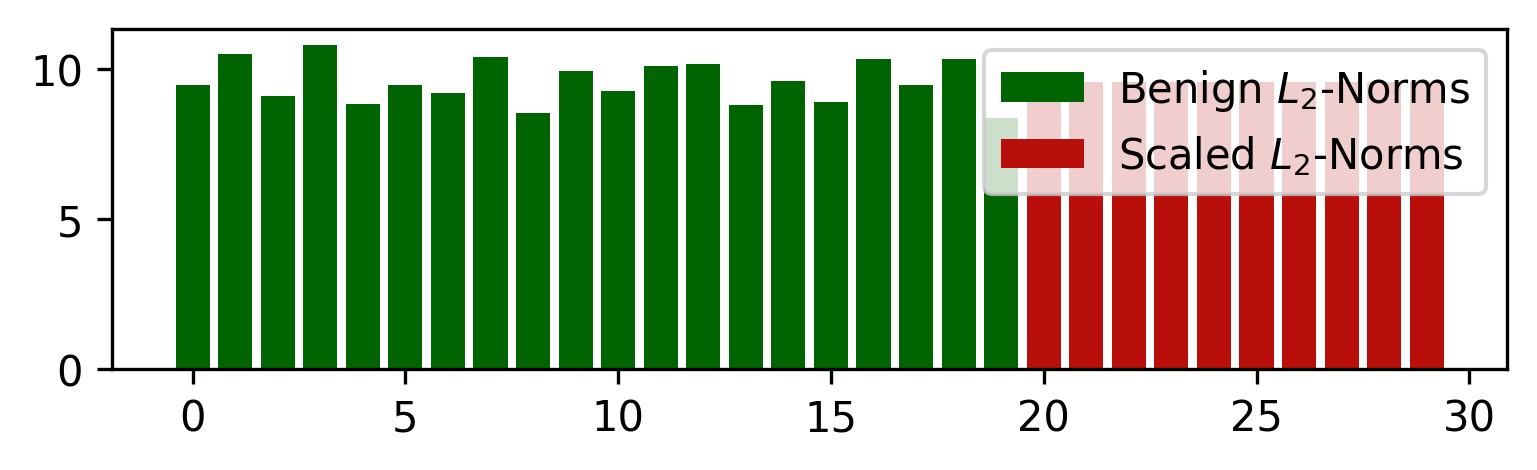

In [ ]:
norms_of_evaision_poisoned_updates = [model_dist_norm(scaled_model, global_model_state_dict_on_cpu, NAMES_OF_AGGREGATED_PARAMETERS) for scaled_model in all_scaled_malicious_models_anomaly_evasion]
plt.figure(dpi=300, figsize=(6,1.5))
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS), norms_of_benign_updates, color='#006400', label='Benign $L_2$-Norms')
plt.bar(np.arange(NUMBER_OF_BENIGN_CLIENTS, TOTAL_CLIENT_NUMBER), norms_of_evaision_poisoned_updates, color='#B80F0A', label='Scaled $L_2$-Norms')
plt.legend()

Now, the $L_2$-norms of the model updates are inconspicious!

In [ ]:
indices_of_accepted_models_ae2 = clustering_defense(all_trained_benign_models + all_scaled_malicious_models_anomaly_evasion)
print_timed(f'The filtering accepted to following models: {indices_of_accepted_models_ae2}')
evaluate_model_filtering(indices_of_accepted_models_ae2, number_of_benign_clients=NUMBER_OF_BENIGN_CLIENTS,number_of_adversaries=NUMBER_OF_ADVERSARIES)

2022-06-14 12:22:17.133333: The filtering accepted to following models: [0, 2, 4, 5, 6, 8, 10, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
2022-06-14 12:22:17.133527: TNR = 60.00%
2022-06-14 12:22:17.133570: TPR = 0.00% (Recall)
2022-06-14 12:22:17.133609: Precision = 0.00%
2022-06-14 12:22:17.133642: F1-Score = 0.00


Clustering is still not able to detect these updates.

### Any Effective defense? 

We use the above code for clipping all updates (after dynamically caclulating the clipping boundary). For clipping and aggregation, we use only the models that were accepted by the clustering but calculate the clipping boundary based on all model updates. Then, we aggregate the models and play around with the attack parameters and try to maximize the BA.

In [ ]:
update_norms = [model_dist_norm(m, global_model_state_dict_on_cpu, NAMES_OF_AGGREGATED_PARAMETERS) for m in tqdm(all_trained_benign_models + all_scaled_malicious_models_anomaly_evasion)]
clipping_boundary = np.median(update_norms)
all_models_ae2 = all_trained_benign_models + all_scaled_malicious_models_anomaly_evasion
all_accepted_models = [all_models_ae2[i] for i in indices_of_accepted_models_ae2]
clipped_models = [clip_update_from_model(m, clipping_boundary) for m in all_accepted_models]
aggregated_weights_clipped = aggregate_models(clipped_models, global_model_state_dict)
aggregated_model.load_state_dict(aggregated_weights_clipped)
evaluate_model(aggregated_model, test_data=test_data, backdoor_test_data=backdoor_test_data)

100%|██████████| 30/30 [00:00<00:00, 139.03it/s]


2022-06-14 12:45:49.887358: Aggregate 22 models
2022-06-14 12:45:51.819287: Performance of AggregatedModel_ResNet_18: MA=32.93 BA=79.00


(32.93, 79.0)

If an effective defense mechanism is not deployed, it might happen that the defense wrongly excludes more benign models than poisoned ones. For example, a bad defense might reject many benign models but accepts most of the poisoned models. Therefore, an ineffective defense can actually increase the PMR meaning that the BA increases.

The (naive) combination of above techniques is not effective against advanced backdoor hiding techniques. If you are interested in this topic, you can try to find a more effective combination of different techniques.

You should also checkout some recent papers on poisoning attacks in FL:
* Nguyen, Thien Duc, et al. "FLAME: Taming Backdoors in Federated Learning." To appear at USENIX Security 2022.
    * https://www.usenix.org/system/files/sec22fall_nguyen.pdf
* Rieger, Phillip, et al. "DeepSight: Mitigating Backdoor Attacks in Federated Learning Through Deep Model Inspection." NDSS 2022.
    * https://www.ndss-symposium.org/wp-content/uploads/2022-156-paper.pdf
* Naseri, Mohammad, Jamie Hayes, and Emiliano De Cristofaro. "Local and central differential privacy for robustness and privacy in federated learning." NDSS 2022.
    * https://www.ndss-symposium.org/wp-content/uploads/2022-54-paper.pdf

If you are interested in this topic and want to discuss it further, please contact us:
* hossein.fereidooni@trust.tu-darmstadt.de
* phillip.rieger@trust.tu-darmstadt.de
* marco.chilese@trust.tu-darmstadt.de
* ahmad.sadeghi@trust.tu-darmstadt.de

## And do not forget:

![](https://media-exp1.licdn.com/dms/image/C4E22AQH6zr3T0UW0bQ/feedshare-shrink_800/0/1592720369091?e=1657152000&v=beta&t=sWwkNyhr-Z5pAQ4omzl33jKknqVPn8M4Sz0VTtiemTk "")